# REINFORCEMENT LEARNING FOR GLUCOSE DYNAMICS - TRAINING AND EVALUATION


## 1. Define Simulator and Gym Environments



### 1.1 Glucose dynamics simulator (```GlucoseDynamicsSimulator```)
- Implements a simplified glucose-insulin-exercise system
- Define state variables, parameterized variables and events

In [ ]:
import numpy as np

class GlucoseDynamicsSimulator:
    """
    Meals are represented by Rameal(t), the rate of glucose appearance from the gut
    Exercise is represented by E_t, e.g. 0 to 1
    Meal and exercise events are represented by boolean flags
    Inputs:
        Rameal_current, E_current, meal_event_occurred, exercise_event_occurred
    State variables:
        G: glucose concentration in the central compartment [mg/dL]
        H: glucose concentration in the skeletal muscle [mg/dL]
        S: interstitial insulin concentration in skeletal muscle [uU/ml]
        M: liver glucose consumption state [unitless]
        L: exercise-action intensity [unitless]
        I_plasma: Plasma insulin concentration [uU/ml]
    Parameterized variables:
        weight [kg]
        Gb: basal glucose concentration [mg/dL]
        Ib: basal insulin concentration [mU/L]
    """

    def __init__(self, weight=70, Gb=90, Ib=15):
        self.weight = weight
        self.Gb = Gb
        self.Ib = Ib

        # metabolic rates [mg/min]
        self.rG_brain = 71
        self.rG_heart = 3.7
        self.rG_kidney = 3.7
        self.rG_gut = 16.6
        self.rG_peri = 45.2 * (self.weight / 70)
        self.rG_liver = 14.8 * (self.weight / 70)

        # EGP basal
        self.EGPb = 155 * (self.weight / 70)  # mg/min

        # skeletal muscle parameters
        self.rG_SMins = 5  # insulin sensitivity [mg/min per uU/ml]
        self.rG_SMexr = 860  # exercise sensitivity [mg/min per unit E]

        # volumes [L]
        self.V_CS_G = 0.07 * weight
        self.V_SM_G = 0.096 * weight
        self.V_SM_tiss = 0.54 * weight
        self.V_SM_I = 0.12 * weight

        # insulin kinetic parameters
        self.rSM_I = 0.02  # 1/min

        # time constants
        self.tau_liver = 25  # min
        self.tau_EGP = 20  # min

        # EGP modulation
        self.eta_EGP = 4  # unitless

        # permeability parameters
        self.PS_dG_rest = 0.01  # ml/min/ml tissue
        self.PS_dI_rest = 0.005  # ml/min/ml tissue

        self.Rd = 1.46  # max cap recruitment factor
        self.gamma = 10  # cap recruitment saturating rate
        self.lambda_d = 1.1  # exercise effect on perfusion

        # hematocrit
        self.h = 0.4

        # plasma insulin dynamics
        self.k_secretion_G = 0.10  # Insulin secretion rate sensitivity to glucose (example value) [uU/ml per mg/dL per min]
        self.k_clearance_I = (
            0.10  # Insulin clearance rate constant (example value) [1/min]
        )
        self.V_plasma_I = (
            0.04 * weight
        )  # Volume of distribution for plasma insulin [L] (example, similar to plasma volume)

    def Qd(self, E):
        return 1.0 + self.lambda_d * E

    def QdI(self, E):
        return (1 - self.h) * self.Qd(E)

    def PSdG(self, E):
        return self.PS_dG_rest * (1 + self.Rd * np.tanh(self.gamma * E))

    def PSdI(self, E):
        return self.PS_dI_rest * (1 + self.Rd * np.tanh(self.gamma * E))

    def kdG(self, E):
        Qd = self.Qd(E)
        PS = self.PSdG(E)
        return Qd * (1 - np.exp(-PS / Qd))

    def kdI(self, E):
        QdI = self.QdI(E)
        PSI = self.PSdI(E)
        return QdI * (1 - np.exp(-PSI / QdI))

    def initial_conditions(self):
        E0 = 0.0
        kdG_rest = self.kdG(E0)
        kdI_rest = self.kdI(E0)

        G0 = self.Gb

        H0 = self.Gb - self.rG_peri / (self.V_SM_tiss * kdG_rest)

        S0 = (self.V_SM_tiss * kdI_rest * self.Ib) / (
            self.rSM_I + self.V_SM_tiss * kdI_rest
        )

        M0 = 1.0
        L0 = 0.0
        I_plasma0 = self.Ib

        time_since_last_meal = 1440  # 24 hours in minutes
        time_since_last_exercise = 1440  # 24 hours in minutes

        return np.array(
            [
                G0,
                H0,
                S0,
                M0,
                L0,
                time_since_last_meal,
                time_since_last_exercise,
                I_plasma0,
            ]
        )

    def odes(self, y, inputs):

        G, H, S, M, L, time_since_last_meal, time_since_last_exercise, I_plasma = y

        (
            Rameal_current,
            E_current,
            meal_event_occurred,
            exercise_event_occurred,
        ) = inputs

        kdG = self.kdG(E_current)
        kdI = self.kdI(E_current)

        RGUCSfix = self.rG_brain + self.rG_heart + self.rG_kidney + self.rG_gut
        RGUCSliv = self.rG_liver * (5.66 + 5.66 * np.tanh(2.44 * (G / 90) - 1.48 * M))
        RGUSMins = self.rG_SMins * (H / 90) * (S / 15) + self.rG_peri
        RGUSMexr = self.rG_SMexr * (H / 90) * E_current

        EGP = self.EGPb * (90 / G) * (15 / S) * (1 + L)

        dGdt = (
            -self.V_SM_tiss * kdG * (G - H) / self.V_CS_G
            - RGUCSliv / self.V_CS_G
            - RGUCSfix / self.V_CS_G
            + Rameal_current / self.V_CS_G
            + EGP / self.V_CS_G
        )

        dHdt = (
            self.V_SM_tiss * kdG * (G - H) / self.V_SM_G
            - RGUSMins / self.V_SM_G
            - RGUSMexr / self.V_SM_G
        )

        dSdt = self.V_SM_tiss * kdI * (I_plasma - S) / self.V_SM_I - self.rSM_I * S

        dMdt = 1.0 / self.tau_liver * (2.0 * np.tanh(0.55 * S / 15))

        dLdt = 1.0 / self.tau_EGP * (-L + self.eta_EGP * E_current)

        d_time_since_last_meal_dt = 1.0
        if meal_event_occurred:
            d_time_since_last_meal_dt = -time_since_last_meal

        d_time_since_last_exercise_dt = 1.0
        if exercise_event_occurred:
            d_time_since_last_exercise_dt = -time_since_last_exercise

        insulin_secretion = max(0, self.k_secretion_G * (G - self.Gb)) * self.V_plasma_I
        insulin_clearance = self.k_clearance_I * I_plasma * self.V_plasma_I
        dI_plasmadt = (insulin_secretion - insulin_clearance) / self.V_plasma_I

        return [
            dGdt,
            dHdt,
            dSdt,
            dMdt,
            dLdt,
            d_time_since_last_meal_dt,
            d_time_since_last_exercise_dt,
            dI_plasmadt,
        ]

### 1.2 Discrete Action Environment (CustomGlucoseDynamicsEnv)
- Action space: ```MultiDiscrete ([ 4, 2, 4, 13 ])```
    - meal_category         ∈ {0: none, 1: light, 2: medium, 3: heavy}
    - exercise_mode         ∈ {0: inactive, 1: start/continue}
    - exercise_intensity    ∈ {0: rest, 1: light, 2: moderate, 3: intense}
    - exercise_duration     ∈ {0…12} → 0–60 min in 5-min steps
- Algorithms used: PPO, TRPO, A2C

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from scipy.integrate import solve_ivp

class CustomGlucoseDynamicsEnv(gym.Env):
    def __init__(self,
                 random_events=True,
                 weight=70.0,       # Can be float (fixed) or tuple (range)
                 Gb=90.0,           # mg/dL
                 Ib=5.7):           # µU/mL

        self.random_events = random_events  # toggle for stochastic events

        '''
            Observation vector:
            [plasma_glucose_concentration, previous_glucose_concentration, plasma_insulin_concentration, time_since last meal, is_breakfast_window, is_lunch_window, is_dinner_window, time_since_last_exercise, current_activity_intensity, time_since_midnight]
        '''
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
            high=np.array([700.0, 700.0, 200.0, 1440.0, 1.0, 1.0, 1.0, 1440.0, 1.0, 1440.0]),
            dtype=np.float32
        )

        '''
            self.action_space = spaces.Dict({
                "meal_category": spaces.Discrete(4),   # 0=no_meal, 1=light, 2=medium, 3=heavy
                "exercise_mode": spaces.Discrete(2),  # 0 = inactive, 1 = start/continue exercise
                "exercise_intensity": spaces.Discrete(4),  # 0 = rest, 1 = light, 2 = moderate, 3 = intense
                "exercise_duration": spaces.Discrete(13), # 0–60 min in 5-min steps
            })
        '''
        self.action_space = spaces.MultiDiscrete([4, 2, 4, 13]) # flattened version

        '''
            weight and glucose range from https://www.moh.gov.my/moh/resources/Penerbitan/CPG/Endocrine/3b.pdf
            insulin range from http://myjurnal.mohe.gov.my/public/article-view.php?id=3564#:~:text=The%20insulin%20sensitivity%20(HOMA%25S,%2C%20BMI%20and%20waist%20circumference).
        '''
        self.weight = weight
        self.Gb = Gb
        self.Ib = Ib

        self.dt = 5                     # 5 minutes

        self.previous_glucose_level = None

        self.simulator = None
        self.simulator_state = None
        self.time_since_midnight = None
        self.current_exercise_session = {
            "active": False,
            "remaining_steps": 0,
            "intensity": 0.0
        }

        self.transition_log = []

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        self.previous_observation = None

        weight = np.random.uniform(*self.weight) if isinstance(self.weight, tuple) else self.weight
        Gb = np.random.uniform(*self.Gb) if isinstance(self.Gb, tuple) else self.Gb
        Ib = np.random.uniform(*self.Ib) if isinstance(self.Ib, tuple) else self.Ib

        self.previous_glucose_level = Gb

        self.simulator = GlucoseDynamicsSimulator(weight=weight, Gb=Gb, Ib=Ib)

        self.simulator_state = self.simulator.initial_conditions()

        G0 = self.simulator_state[0]
        I_plasma0 = self.simulator_state[7]
        time_since_last_meal = self.simulator_state[5]
        time_since_last_exercise = self.simulator_state[6]

        self.time_since_midnight = 0.0

        is_breakfast_window = 1.0 if 6*60 <= self.time_since_midnight < 9*60 else 0.0
        is_lunch_window = 1.0 if 12*60 <= self.time_since_midnight < 14*60 else 0.0
        is_dinner_window = 1.0 if 18*60 <= self.time_since_midnight < 20*60 else 0.0

        self.current_exercise_session = {
            "active": False,
            "remaining_steps": 0,
            "intensity": 0.0
        }

        observed_state = np.array([
            G0,
            self.previous_glucose_level,
            I_plasma0,
            time_since_last_meal,
            is_breakfast_window,
            is_lunch_window,
            is_dinner_window,
            time_since_last_exercise,
            self.current_exercise_session["intensity"],
            self.time_since_midnight
        ], dtype=np.float32)

        self.previous_observation = observed_state.copy()

        return observed_state, {}

    def build_observation(self):
        G0 = self.simulator_state[0]
        I_plasma0 = self.simulator_state[7]
        time_since_last_meal = self.simulator_state[5]
        time_since_last_exercise = self.simulator_state[6]

        self.time_since_midnight += self.dt

        is_breakfast_window = 1.0 if 6*60 <= self.time_since_midnight < 9*60 else 0.0
        is_lunch_window = 1.0 if 12*60 <= self.time_since_midnight < 14*60 else 0.0
        is_dinner_window = 1.0 if 18*60 <= self.time_since_midnight < 20*60 else 0.0

        temp_state = np.array([
            G0,
            self.previous_glucose_level,
            I_plasma0,
            time_since_last_meal,
            is_breakfast_window,
            is_lunch_window,
            is_dinner_window,
            time_since_last_exercise,
            self.simulator_state[4],
            self.time_since_midnight
        ], dtype=np.float32)

        return temp_state

    def refresh_observation(self):
        G0 = self.simulator_state[0]
        I_plasma0 = self.simulator_state[7]
        time_since_last_meal = self.simulator_state[5]
        time_since_last_exercise = self.simulator_state[6]

        is_breakfast_window = 1.0 if 6*60 <= self.time_since_midnight < 9*60 else 0.0
        is_lunch_window = 1.0 if 12*60 <= self.time_since_midnight < 14*60 else 0.0
        is_dinner_window = 1.0 if 18*60 <= self.time_since_midnight < 20*60 else 0.0

        obs = np.array([
            G0,
            self.previous_glucose_level,
            I_plasma0,
            time_since_last_meal,
            is_breakfast_window,
            is_lunch_window,
            is_dinner_window,
            time_since_last_exercise,
            self.simulator_state[4],
            self.time_since_midnight
        ], dtype=np.float32)

        return obs

    def step(self, action):
        meal_category = action[0]
        exercise_mode = action[1]
        exercise_intensity = action[2]
        exercise_duration = action[3]
        Rameal_current = self.map_meal_category_to_glucose_rate(meal_category)

        #random meal (increase environment instability)
        meal_event_occurred = meal_category > 0
        if self.random_events:
            if np.random.rand() < 0.05:
                random_meal_g = np.random.uniform(5,20)
                random_meal_rate = random_meal_g * 1000 / 60
                Rameal_current += random_meal_rate
                meal_event_occurred = True

        if exercise_mode == 1:
            if not self.current_exercise_session["active"]:
                self.current_exercise_session["active"] = True
                self.current_exercise_session["remaining_steps"] = exercise_duration
                self.current_exercise_session["intensity"] = self.map_exercise_level_to_intensity(exercise_intensity)
        else:
            self.current_exercise_session["active"] = False
            self.current_exercise_session["remaining_steps"] = 0
            self.current_exercise_session["intensity"] = 0.0

        if self.current_exercise_session["active"]:
            self.current_exercise_session["remaining_steps"] -= 1
            if self.current_exercise_session["remaining_steps"] <= 0:
                self.current_exercise_session["active"] = False
                self.current_exercise_session["intensity"] = 0.0

        E_current = self.current_exercise_session["intensity"]

        #random exercise (increase environment instability)
        exercise_event_occurred = exercise_mode == 1
        if self.random_events:
            if np.random.rand() < 0.03:
                random_exercise_intensity = np.random.uniform(0.2, 0.8)
                E_current += random_exercise_intensity
                E_current = float(np.clip(E_current, 0.0, 1.0))
                exercise_event_occurred = True

        ode_func = lambda t, y: self.simulator.odes(
            y,
            (Rameal_current, E_current, meal_event_occurred, exercise_event_occurred)
        )

        sol = solve_ivp(
            ode_func,
            t_span=(0, self.dt),
            y0=self.simulator_state,
            method="RK45",
            max_step=0.5
        )

        self.simulator_state = sol.y[:, -1]

        obs = self.build_observation()
        obs[0] = self.add_observation_noise(obs[0])

        reward = self.compute_reward(action, obs)

        terminated = bool((obs[0] < 40) or (obs[0] > 450))
        truncated = obs[-1] >= 1440

        self.previous_glucose_level = obs[0]

        # log transition
        self.transition_log.append({
            "state": self.previous_observation.copy(),
            "action": action.copy() if isinstance(action, dict) else np.array(action),
            "reward": reward,
            "next_state": obs.copy(),
            "done": terminated or truncated
        })
        self.previous_observation = obs.copy()

        return obs, reward, terminated, truncated, {}


    def map_meal_category_to_glucose_rate(self, category):
        '''
        References:
            American Diabetes Association, 2022 Standards of Care
            Diabetes Care. 2019;42(4):731–739. “Postprandial glucose: physiology and clinical significance.”
            OGTT kinetics: WHO/IDF guidelines on carbohydrate absorption
        '''
        rates = [
            0.0,    # no meal
            0.45,   # light meal (30g carbs over 90 min)
            0.65,   # medium meal (60g carbs over 120 min)
            0.8     # heavy meal (90g carbs over 150 min)
        ]
        return rates[category]

    def map_exercise_level_to_intensity(self, level):
        '''
        References:
            Ainsworth BE et al., 2011. Compendium of Physical Activities
            J Appl Physiol. 2017;122(4):889–901. “Glucose metabolism and exercise.”
            ADA 2022: exercise recommendations
        '''
        intensities = [
            0.0,  # at rest
            0.3,  # light activity (2–3 METS)
            0.6,  # moderate activity (4–6 METS)
            0.9   # intense (7–10 METS)
        ]
        return intensities[level]

    def add_observation_noise(self, glucose_reading):
        '''
            add noises into the glucose measurement to simulate the real life situation
        '''
        noise = np.random.normal(loc=0, scale=5.0)
        return glucose_reading + noise

    def compute_reward(self, action, obs):
        meal_category = action[0]
        exercise_mode = action[1]

        # can be also calculated by scaling the penalty using the distance between glucose level and target glucose
        reward = 0.0

        # penalty for taking meal outside the meal windows
        time_since_last_meal = obs[3] # From the state vector
        is_breakfast_window = obs[4]
        is_lunch_window = obs[5]
        is_dinner_window = obs[6]

        if meal_category != 0 and not (is_breakfast_window or is_lunch_window or is_dinner_window):
            reward -= 50

        # action penalty
        if meal_category != 0 and exercise_mode != 0:
            reward += -30

        # state-dependent glucose reward or panalty
        glucose_level = obs[0] # plasma glucose concentration

        if time_since_last_meal > 8 * 60:
            if 70 <= glucose_level <= 100:
                reward += 100.0
            elif 101 <= glucose_level <= 125:
                reward += -30.0
            elif glucose_level < 70:
                reward += -100.0
            elif glucose_level > 125:
                reward += -100.0

        elif time_since_last_meal <= 2 * 60:
            if glucose_level <= 140:
                reward += 80.0
            elif 141 <= glucose_level <= 199:
                reward += -20.0
            elif glucose_level < 70:
                reward += -100.0
            elif glucose_level > 200:
                reward += -100.0

        else:
            if 70 <= glucose_level <= 120:
                reward += 50.0
            elif 121 <= glucose_level <= 140:
                reward += -15.0
            elif glucose_level < 70:
                reward += -100.0
            elif glucose_level > 140:
                reward += -100.0

        # penalty for high variability when agent choose no meals and no exercise
        agent_inactive = meal_category == 0 and exercise_mode == 0

        if agent_inactive and (70 <= glucose_level <= 180):

            glucose_change = abs(glucose_level - self.previous_glucose_level)

            variability_threshold = 10.0
            variability_penalty_per_unit_over_threshold = -5

            if glucose_change > variability_threshold:
                reward += variability_penalty_per_unit_over_threshold * (glucose_change - variability_threshold)

        # critical state penalty
        if glucose_level < 40 or glucose_level > 450:
            reward -= 100

        return reward

    def clone_state(self):
        return {
            "simulator_state": self.simulator_state.copy(),
            "time_since_midnight": self.time_since_midnight,
            "previous_glucose_level": self.previous_glucose_level,
            "current_exercise_session": self.current_exercise_session.copy(),
            "previous_observation": self.previous_observation.copy(),
        }

    def restore_state(self, state_dict):
        self.simulator_state = state_dict["simulator_state"].copy()
        self.time_since_midnight = state_dict["time_since_midnight"]
        self.previous_glucose_level = state_dict["previous_glucose_level"]
        self.current_exercise_session = state_dict["current_exercise_session"].copy()
        self.previous_observation = state_dict["previous_observation"].copy()

    def toggle_random_events(self, enable):
        self.random_events = enable

    def force_action(self, meal_category=0, exercise_mode=0, exercise_intensity=0, exercise_duration=0):
        """
        Force the environment to execute a specific action.

        :param meal_category: 0=no meal, 1=light, 2=medium, 3=heavy
        :param exercise_mode: 0=inactive, 1=exercise
        :param exercise_intensity: 0=rest, 1=light, 2=moderate, 3=intense
        :param exercise_duration: duration in discrete steps (0–12 corresponding to 0–60 minutes)
        """
        action = np.array([meal_category, exercise_mode, exercise_intensity, exercise_duration], dtype=int)
        return self.step(action)


### 1.3 Continuous Action Environment (```CustomGlucoseDynamicsEnvBox```)
- Action space: ```Box (4, )``` ∈ [ 0, 1 ]
    - Internally quantized via ```continuous_to_discrete(...)``` to same four action factors as Discrete Action Environment
        - meal_category      
        - exercise_mode       
        - exercise_intensity   
        - exercise_duration
- Algorithm used: SAC

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from scipy.integrate import solve_ivp

class CustomGlucoseDynamicsEnvBox(gym.Env):
    def __init__(self,
                 random_events=True,
                 weight=70.0,       # Can be float (fixed) or tuple (range)
                 Gb=90.0,           # mg/dL
                 Ib=5.7):           # µU/mL

        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
            high=np.array([700.0, 700.0, 200.0, 1440.0, 1.0, 1.0, 1.0, 1440.0, 1.0, 1440.0]),
            dtype=np.float32
        )

        self.random_events = random_events

        self.action_space = spaces.Box(low=np.array([0, 0, 0, 0]), high=np.array([1, 1, 1, 1]), dtype=np.float32)

        self.weight = weight
        self.Gb = Gb
        self.Ib = Ib

        self.dt = 5
        self.previous_glucose_level = None

        self.simulator = None
        self.simulator_state = None
        self.time_since_midnight = None
        self.current_exercise_session = {
            "active": False,
            "remaining_steps": 0,
            "intensity": 0.0
        }

        self.transition_log = []

    def continuous_to_discrete(self, action):
        action = np.clip(action, 0.0, 1.0)
        meal = int(np.round(action[0] * 3))
        mode = int(np.round(action[1]))
        intensity = int(np.round(action[2] * 3))
        duration = int(np.round(action[3] * 12))
        return [meal, mode, intensity, duration]

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.previous_observation = None

        weight = np.random.uniform(*self.weight) if isinstance(self.weight, tuple) else self.weight
        Gb = np.random.uniform(*self.Gb) if isinstance(self.Gb, tuple) else self.Gb
        Ib = np.random.uniform(*self.Ib) if isinstance(self.Ib, tuple) else self.Ib

        self.previous_glucose_level = Gb
        self.simulator = GlucoseDynamicsSimulator(weight=weight, Gb=Gb, Ib=Ib)
        self.simulator_state = self.simulator.initial_conditions()

        G0 = self.simulator_state[0]
        I_plasma0 = self.simulator_state[7]
        time_since_last_meal = self.simulator_state[5]
        time_since_last_exercise = self.simulator_state[6]

        self.time_since_midnight = 0.0
        is_breakfast_window = 1.0 if 6*60 <= self.time_since_midnight < 9*60 else 0.0
        is_lunch_window = 1.0 if 12*60 <= self.time_since_midnight < 14*60 else 0.0
        is_dinner_window = 1.0 if 18*60 <= self.time_since_midnight < 20*60 else 0.0

        self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        observed_state = np.array([
            G0, self.previous_glucose_level, I_plasma0, time_since_last_meal,
            is_breakfast_window, is_lunch_window, is_dinner_window,
            time_since_last_exercise, self.current_exercise_session["intensity"], self.time_since_midnight
        ], dtype=np.float32)

        self.previous_observation = observed_state.copy()
        return observed_state, {}

    def build_observation(self):
        G0 = self.simulator_state[0]
        I_plasma0 = self.simulator_state[7]
        time_since_last_meal = self.simulator_state[5]
        time_since_last_exercise = self.simulator_state[6]

        self.time_since_midnight += self.dt

        is_breakfast_window = 1.0 if 6*60 <= self.time_since_midnight < 9*60 else 0.0
        is_lunch_window = 1.0 if 12*60 <= self.time_since_midnight < 14*60 else 0.0
        is_dinner_window = 1.0 if 18*60 <= self.time_since_midnight < 20*60 else 0.0

        return np.array([
            G0, self.previous_glucose_level, I_plasma0, time_since_last_meal,
            is_breakfast_window, is_lunch_window, is_dinner_window,
            time_since_last_exercise, self.simulator_state[4], self.time_since_midnight
        ], dtype=np.float32)

    def step(self, action):
        action = self.continuous_to_discrete(action)
        meal_category, exercise_mode, exercise_intensity, exercise_duration = action
        Rameal_current = self.map_meal_category_to_glucose_rate(meal_category)

        if self.random_events and np.random.rand() < 0.05:
            Rameal_current += np.random.uniform(5,20) * 1000 / 60
            meal_event_occurred = True
        else:
            meal_event_occurred = meal_category > 0

        if exercise_mode == 1:
            if not self.current_exercise_session["active"]:
                self.current_exercise_session["active"] = True
                self.current_exercise_session["remaining_steps"] = exercise_duration
                self.current_exercise_session["intensity"] = self.map_exercise_level_to_intensity(exercise_intensity)
        else:
            self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        if self.current_exercise_session["active"]:
            self.current_exercise_session["remaining_steps"] -= 1
            if self.current_exercise_session["remaining_steps"] <= 0:
                self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        E_current = self.current_exercise_session["intensity"]

        if self.random_events and np.random.rand() < 0.03:
            E_current += np.random.uniform(0.2, 0.8)
            E_current = np.clip(E_current, 0.0, 1.0)
            exercise_event_occurred = True
        else:
            exercise_event_occurred = exercise_mode == 1

        ode_func = lambda t, y: self.simulator.odes(
            y, (Rameal_current, E_current, meal_event_occurred, exercise_event_occurred))

        sol = solve_ivp(
            ode_func, t_span=(0, self.dt), y0=self.simulator_state,
            method="RK45", max_step=0.5
        )

        self.simulator_state = sol.y[:, -1]
        obs = self.build_observation()
        obs[0] = self.add_observation_noise(obs[0])
        reward = self.compute_reward(action, obs)

        terminated = bool((obs[0] < 40) or (obs[0] > 450))
        truncated = obs[-1] >= 1440

        self.previous_glucose_level = obs[0]
        self.transition_log.append({
            "state": self.previous_observation.copy(),
            "action": np.array(action),
            "reward": reward,
            "next_state": obs.copy(),
            "done": terminated or truncated
        })
        self.previous_observation = obs.copy()
        return obs, reward, terminated, truncated, {}

    def map_meal_category_to_glucose_rate(self, category):
        return [0.0, 0.45, 0.65, 0.8][category]

    def map_exercise_level_to_intensity(self, level):
        return [0.0, 0.3, 0.6, 0.9][level]

    def add_observation_noise(self, glucose_reading):
        return glucose_reading + np.random.normal(loc=0, scale=5.0)

    def compute_reward(self, action, obs):
        meal_category, exercise_mode = action[0], action[1]
        reward = 0.0
        time_since_last_meal = obs[3]
        windows = obs[4:7]
        if meal_category != 0 and not any(windows):
            reward += -50
        if meal_category != 0 and exercise_mode != 0:
            reward += -30
        glucose_level = obs[0]

        if time_since_last_meal > 480:
            reward += 100.0 if 70 <= glucose_level <= 100 else -30.0 if glucose_level <= 125 else -100.0
        elif time_since_last_meal <= 120:
            reward += 80.0 if glucose_level <= 140 else -20.0 if glucose_level <= 199 else -100.0
        else:
            reward += 50.0 if 70 <= glucose_level <= 120 else -15.0 if glucose_level <= 140 else -100.0

        if meal_category == 0 and exercise_mode == 0 and 70 <= glucose_level <= 180:
            change = abs(glucose_level - self.previous_glucose_level)
            if change > 10:
                reward += -5 * (change - 10)

        if glucose_level < 40 or glucose_level > 450:
            reward -= 100

        return reward

    def toggle_random_events(self, enable):
        self.random_events = enable

    def clone_state(self):
        return {
            "simulator_state": self.simulator_state.copy(),
            "time_since_midnight": self.time_since_midnight,
            "previous_glucose_level": self.previous_glucose_level,
            "current_exercise_session": self.current_exercise_session.copy(),
            "previous_observation": self.previous_observation.copy(),
        }

    def restore_state(self, state_dict):
        self.simulator_state = state_dict["simulator_state"].copy()
        self.time_since_midnight = state_dict["time_since_midnight"]
        self.previous_glucose_level = state_dict["previous_glucose_level"]
        self.current_exercise_session = state_dict["current_exercise_session"].copy()
        self.previous_observation = state_dict["previous_observation"].copy()

    def force_action(self, meal_category=0, exercise_mode=0, exercise_intensity=0, exercise_duration=0):
        normalized_action = np.array([
            meal_category / 3,
            exercise_mode,
            exercise_intensity / 3,
            exercise_duration / 12
        ])
        return self.step(normalized_action)

## 2. Baseline Training
For each algorithms, we do
1. Builds the env
2. Wraps with ```Monitor```
3. Instantiates model with baseline hyperparameters
4. Training for ```total_timesteps = 100000```
5. Save model, logs and tensorboard

After train, the following file will saved in the respective path
- Model       : ```./saved_models/{algo}_glucose_model```
- Logs        : ```./logs/{algo}_logs/monitor.csv```
- Tensorboard : ```./logs/{algo}_tensorboard/```

In [ ]:
TOTAL_OPTUNA_TIMESTAMPS = 20_000
OPTUNA_TRIALS = 20
TOTAL_TRAINING_TIMESTAMPS=100_000

### 2.1 PPO (```stable_baselines3```)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor


os.makedirs("./logs/ppo_logs/", exist_ok=True)
os.makedirs("./logs/ppo_tensorboard/", exist_ok=True)
os.makedirs("./saved_models/", exist_ok=True)

env = CustomGlucoseDynamicsEnv()
env = Monitor(env, filename="./logs/ppo_logs/")

model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log="./logs/ppo_tensorboard/",
    learning_rate=3e-4,
    gamma=0.99,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
)

model.learn(total_timesteps=TOTAL_TRAINING_TIMESTAMPS)

env.close()
model.save("./saved_models/ppo_glucose_model")
print("PPO Training completed and model saved.")

c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


PPO Training completed and model saved.


### 2.2 TRPO (```sb3_contrib```)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sb3_contrib import TRPO
from stable_baselines3.common.monitor import Monitor

os.makedirs("./logs/trpo_logs/", exist_ok=True)
os.makedirs("./logs/trpo_tensorboard/", exist_ok=True)
os.makedirs("./saved_models/", exist_ok=True)

env = CustomGlucoseDynamicsEnv()
env = Monitor(env, filename="./logs/trpo_logs/")

model = TRPO(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log="./logs/trpo_tensorboard/",
    learning_rate=3e-4,
    gamma=0.99,
    n_steps=2048,
    batch_size=64,
)

model.learn(total_timesteps=TOTAL_TRAINING_TIMESTAMPS)

env.close()
model.save("./saved_models/trpo_glucose_model")
print("TRPO Training completed and model saved.")

c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


TRPO Training completed and model saved.


### 2.3 A2C (```stable_baselines3```)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

os.makedirs("./logs/a2c_logs/", exist_ok=True)
os.makedirs("./logs/a2c_tensorboard/", exist_ok=True)
os.makedirs("./saved_models/", exist_ok=True)

env = CustomGlucoseDynamicsEnv()
env = Monitor(env, filename="./logs/a2c_logs/")

model = A2C(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log="./logs/a2c_tensorboard/",
    learning_rate=3e-4,
    gamma=0.99,
    n_steps=5,
    ent_coef=0.01,
    vf_coef=0.5
)

model.learn(total_timesteps=TOTAL_TRAINING_TIMESTAMPS)
env.close()
model.save("./saved_models/a2c_glucose_model")
print("A2C Training completed and model saved.")

c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


A2C Training completed and model saved.


### 2.4 A2C (```stable_baselines3```)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor

def main():
    os.makedirs("./logs/sac_logs/", exist_ok=True)
    os.makedirs("./logs/sac_tensorboard/", exist_ok=True)
    os.makedirs("./saved_models/", exist_ok=True)

    env = CustomGlucoseDynamicsEnvBox()
    env = Monitor(env, filename="./logs/sac_logs/")

    model = SAC(
        "MlpPolicy",
        env,
        verbose=0,
        tensorboard_log="./logs/sac_tensorboard/",
        learning_rate=3e-4,
        gamma=0.99,
        buffer_size=TOTAL_TRAINING_TIMESTAMPS,
        batch_size=64,
        train_freq=1,
        gradient_steps=1,
    )

    model.learn(total_timesteps=TOTAL_TRAINING_TIMESTAMPS)

    env.close()
    model.save("./saved_models/sac_glucose_model")
    print("SAC Training completed and model saved.")

if __name__ == "__main__":
    main()


c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


SAC Training completed and model saved.


## 3. Evaluation & Cross-Algorithm Comparison for Baseline Training
By using ```monitor.csv``` from each baseline training and computes the following:
- Reward Trend (per episode) : ```./figures_comparison/reward_trend.png```
- Smoothed Reward (moving average of window 20) : ```./figures_comparison/reward_smoothed.png```
- Coefficient of Variation (CV) : ```./figures_comparison/reward_cv.png```
- Average Time per Step (s) (derived from  monitor.csv times) → ```./figures_comparison/avg_step_time.png```
- Total Training Time (s) : ```./figures_comparison/total_training_time.png```
- Summary table : ```./figures_comparison/summary_table.csv```
    - Algorithm
    - Mean Reward (last 50)
    - Max Reward
    - Min Reward
    - Std Reward
    - Avg Time per Step (s)
    - Total Training Time (s)


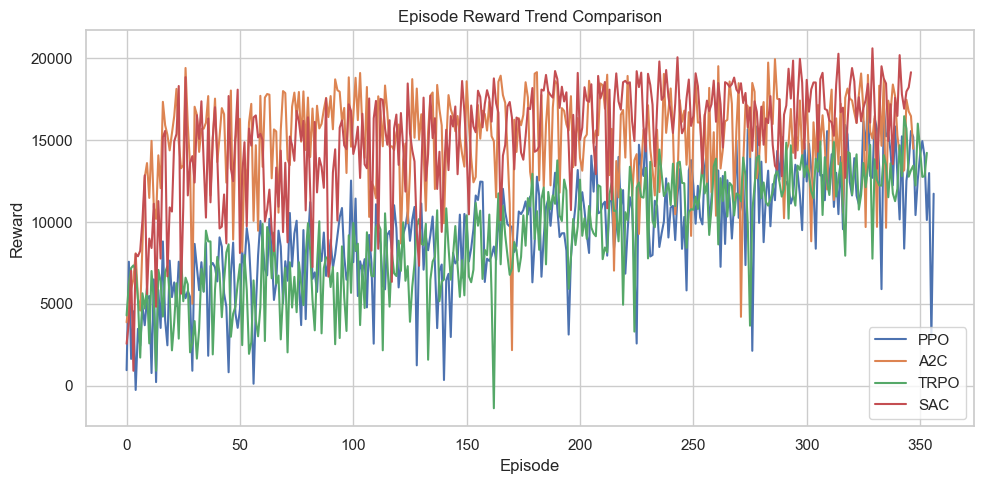

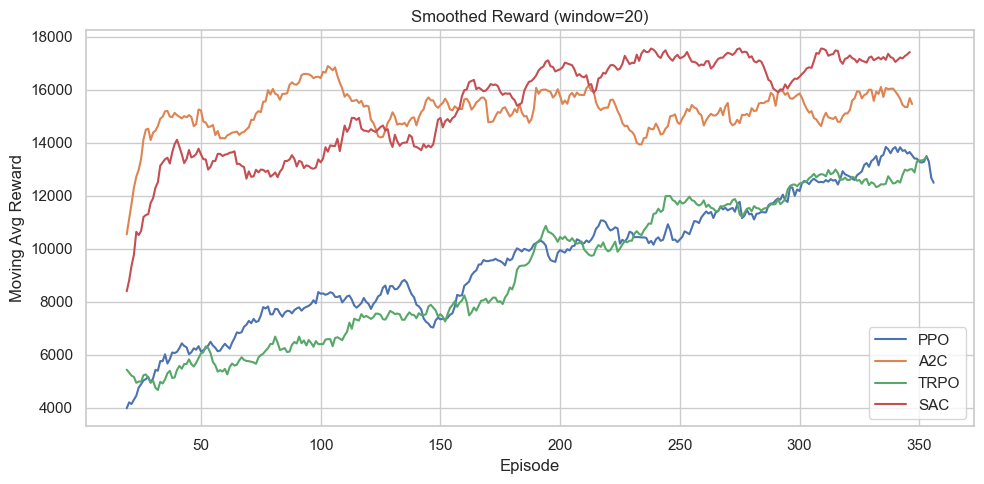

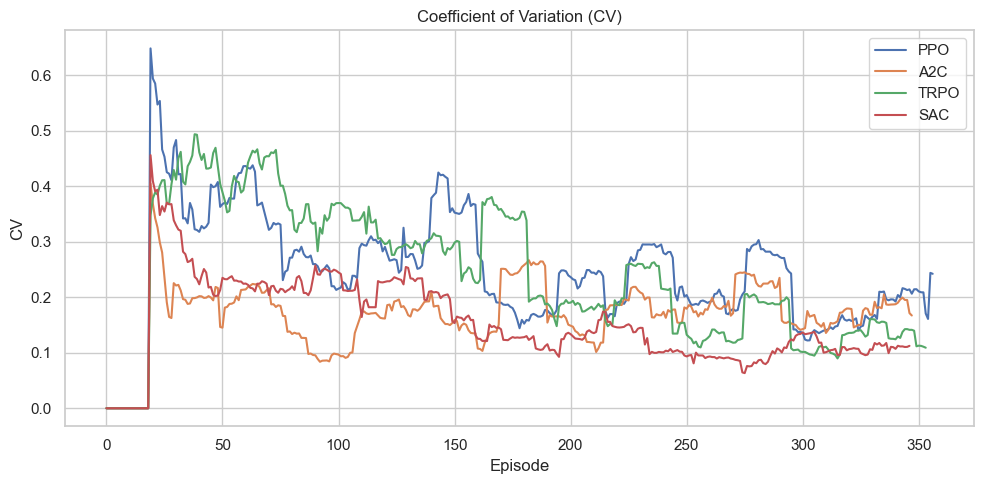

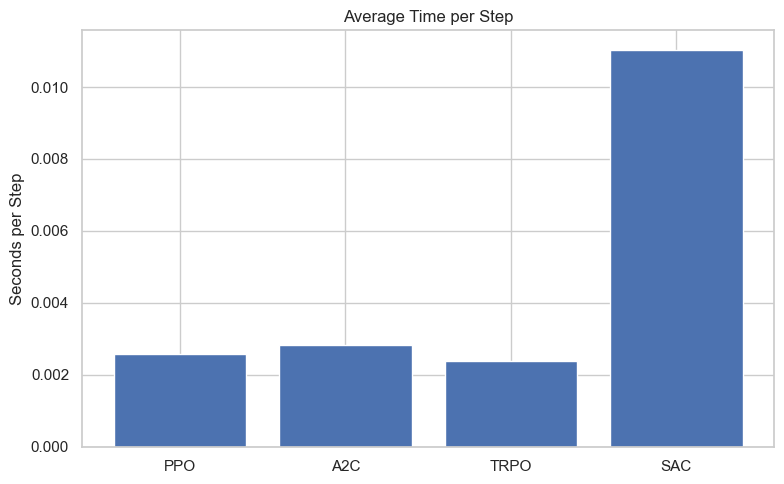

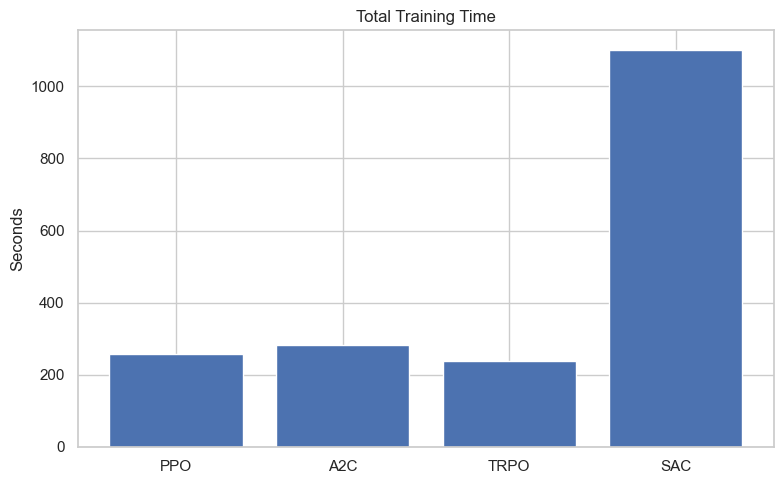

Performance Summary:


,Algorithm,Mean Reward (last 50),Max Reward,Min Reward,Std Reward,Avg Time per Step (s),Total Training Time (s)
0,PPO,13008.86,17693.70,-250.67,3462.40,0.002588,257.53
1,A2C,15466.80,19945.00,2180.00,3028.96,0.002824,281.83
2,TRPO,12936.28,16461.12,-1367.63,3428.81,0.002387,238.72
3,SAC,17339.00,20605.00,919.87,3380.83,0.011022,1100.38



Diagrams are saved at ./figures_comparison/ and summary saved as summary_table.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
FIG_DIR = "./figures_comparison"
os.makedirs(FIG_DIR, exist_ok=True)

algos = ["ppo", "a2c", "trpo", "sac"]

def load_data(algo):
    path = f"./logs/{algo}_logs/monitor.csv"
    df = pd.read_csv(path, skiprows=2, names=["reward", "length", "time"])

    df["episode_time"] = df["time"].diff().fillna(0)
    df["step_time"] = df["episode_time"] / df["length"]
    return df

data = {algo: load_data(algo) for algo in algos}
rewards = {algo: data[algo]["reward"].values for algo in algos}
step_times = {algo: data[algo]["step_time"].values[1:] for algo in algos}
total_times = {algo: data[algo]["time"].iloc[-1] for algo in algos}

def plot_rewards():
    plt.figure(figsize=(10,5))
    for algo in algos:
        plt.plot(rewards[algo], label=algo.upper())
    plt.title("Episode Reward Trend Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/reward_trend.png")
    plt.show()

def plot_smoothed(window=20):
    plt.figure(figsize=(10,5))
    for algo in algos:
        sm = pd.Series(rewards[algo]).rolling(window).mean()
        plt.plot(sm, label=algo.upper())
    plt.title(f"Smoothed Reward (window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Moving Avg Reward")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/reward_smoothed.png")
    plt.show()

def plot_cv(window=20):
    plt.figure(figsize=(10,5))
    for algo in algos:
        series = pd.Series(rewards[algo])
        means = series.rolling(window).mean()
        stds  = series.rolling(window).std()
        cv = (stds / means).fillna(0)
        plt.plot(cv, label=algo.upper())
    plt.title("Coefficient of Variation (CV)")
    plt.xlabel("Episode")
    plt.ylabel("CV")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/reward_cv.png")
    plt.show()

def plot_avg_step_time():
    plt.figure(figsize=(8,5))
    avg_times = [np.mean(step_times[algo]) for algo in algos]
    plt.bar([a.upper() for a in algos], avg_times)
    plt.title("Average Time per Step")
    plt.ylabel("Seconds per Step")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/avg_step_time.png")
    plt.show()

def plot_total_training_time():
    plt.figure(figsize=(8,5))
    total_time_values = [total_times[algo] for algo in algos]
    plt.bar([a.upper() for a in algos], total_time_values)
    plt.title("Total Training Time")
    plt.ylabel("Seconds")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/total_training_time.png")
    plt.show()

plot_rewards()
plot_smoothed(window=20)
plot_cv(window=20)
plot_avg_step_time()
plot_total_training_time()

summary = []
for algo in algos:
    r = rewards[algo]
    t = step_times[algo]
    summary.append({
        "Algorithm": algo.upper(),
        "Mean Reward (last 50)": np.round(r[-50:].mean(),2) if len(r)>=50 else np.nan,
        "Max Reward": np.round(r.max(),2),
        "Min Reward": np.round(r.min(),2),
        "Std Reward": np.round(r.std(),2),
        "Avg Time per Step (s)": np.round(np.mean(t), 6),
        "Total Training Time (s)": np.round(total_times[algo], 2)
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv(f"{FIG_DIR}/summary_table.csv", index=False)

print("Performance Summary:")
display(summary_df)
print(f"\nDiagrams are saved at {FIG_DIR}/ and summary saved as summary_table.csv")


## 4. Hyperparameter Tuning with Optuna
For each algorithms, we define parameters and respective search space to be optimize, Optuna will self-learn and find the best which fulfill the target within the number of trials that we set, and save file in each respective path
- Optuna target: Maximize reward
- Number of trials: 20
- Training total_timesteps per trial = 20000
- Reward curve per trial : ```./results/optuna/{algo}/reward_curves/trial_{n}.png```
- Trial CSV : ```./results/optuna/{algo}/csv/trials.csv```
- Best model : ```./results/optuna/{algo}/best_model/model.zip```
- Tensorboard : ```./results/optuna/{algo}/tensorboard/```


### 4.1 PPO
Search space:
- ```learning_rate ∈ [1e-5, 1e-3]```
- ```n_steps ∈ {512, 1024, 2048}```
- ```batch_size ∈ {32, 64, 128}```
- ```gamma ∈ [0.95, 0.999]```
- ```n_epochs ∈ {5, 10, 20}```
- ```ent_coef ∈ [1e-4, 1e-3]```

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.logger import configure

BASE_DIR = "results/optuna/ppo"
os.makedirs(f"{BASE_DIR}/csv", exist_ok=True)
os.makedirs(f"{BASE_DIR}/reward_curves", exist_ok=True)
os.makedirs(f"{BASE_DIR}/best_model", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tensorboard", exist_ok=True)

# Reward tracking
def track_reward_during_training(model, env, num_episodes, trial_num):
    rewards = []
    episode_lengths = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        episode_lengths.append(steps)

    print(f"[Trial {trial_num}] Avg Ep Length: {np.mean(episode_lengths):.1f}")
    print(f"[Trial {trial_num}] Last 20 Ep Avg Reward: {np.mean(rewards[-20:]):.2f}")

    # plot rewards
    plt.figure()
    plt.plot(rewards)
    plt.title(f"Trial {trial_num}: Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/reward_curves/trial_{trial_num}.png")
    plt.close()

    return np.mean(rewards[-20:]) if len(rewards) >= 20 else np.mean(rewards)

# Optuna hyperparameter optimization
def optimize_ppo(trial):
    # Define hyperparameters range
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    n_steps = trial.suggest_categorical("n_steps", [512, 1024, 2048])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    gamma = trial.suggest_float("gamma", 0.95, 0.999)
    n_epochs = trial.suggest_categorical("n_epochs", [5, 10, 20])
    ent_coef = trial.suggest_float("ent_coef", 1e-4, 1e-3, log=True)

    # Environment setup
    env = DummyVecEnv([lambda: Monitor(CustomGlucoseDynamicsEnv())])
    env = VecMonitor(env)

    # TensorBoard logging setup
    tb_log_dir = f"{BASE_DIR}/tensorboard/trial_{trial.number}"
    logger = configure(tb_log_dir, ["tensorboard"])

    # Initialize model
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        gamma=gamma,
        n_epochs=n_epochs,
        ent_coef=ent_coef,
        verbose=0,
        tensorboard_log=tb_log_dir,
    )
    model.set_logger(logger)

    # Train
    model.learn(total_timesteps=TOTAL_OPTUNA_TIMESTAMPS)

    # Evaluate
    eval_env = CustomGlucoseDynamicsEnv()
    mean_reward = track_reward_during_training(model, eval_env, num_episodes=20, trial_num=trial.number)

    # Save best model
    if not hasattr(optimize_ppo, "best_reward"):
        optimize_ppo.best_reward = -np.inf
    if mean_reward > optimize_ppo.best_reward:
        optimize_ppo.best_reward = mean_reward
        model.save(f"{BASE_DIR}/best_model/model")

    env.close()
    return mean_reward

# Main execution
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_ppo, n_trials=OPTUNA_TRIALS)

    study.trials_dataframe().to_csv(f"{BASE_DIR}/csv/trials.csv", index=False)
    print("PPO Optuna Done")
    print("Best trial:")
    print(study.best_trial)

c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-27 00:57:44,490] A new study created in memory with name: no-name-d04dcad0-9e9e-4f0c-895d-3e70b097f9b0
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `Vec

[Trial 0] Avg Ep Length: 288.0
[Trial 0] Last 20 Ep Avg Reward: 5830.45


c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
[I 2025-08-27 00:59:46,522] Trial 1 finished with value: 11921.439453125 and parameters: {'learning_rate': 0.0007895092472988409, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.970068996523132, 'n_epochs': 10, 'ent_coef': 0.0004256007133458936}. Best is trial 1 with value: 11921.439453125.


[Trial 1] Avg Ep Length: 280.1
[Trial 1] Last 20 Ep Avg Reward: 11921.44


[I 2025-08-27 01:01:05,942] Trial 2 finished with value: 13156.111328125 and parameters: {'learning_rate': 0.0004661395654399054, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9904817288026739, 'n_epochs': 20, 'ent_coef': 0.00013683935143501638}. Best is trial 2 with value: 13156.111328125.


[Trial 2] Avg Ep Length: 288.0
[Trial 2] Last 20 Ep Avg Reward: 13156.11


[I 2025-08-27 01:01:59,766] Trial 3 finished with value: 5094.888671875 and parameters: {'learning_rate': 3.2932948513728284e-05, 'n_steps': 512, 'batch_size': 128, 'gamma': 0.9661379859857729, 'n_epochs': 10, 'ent_coef': 0.00011213431043471893}. Best is trial 2 with value: 13156.111328125.


[Trial 3] Avg Ep Length: 268.9
[Trial 3] Last 20 Ep Avg Reward: 5094.89


[I 2025-08-27 01:03:10,909] Trial 4 finished with value: 7015.68505859375 and parameters: {'learning_rate': 8.018840870808377e-05, 'n_steps': 2048, 'batch_size': 32, 'gamma': 0.9815620143724088, 'n_epochs': 10, 'ent_coef': 0.0002113529285042489}. Best is trial 2 with value: 13156.111328125.


[Trial 4] Avg Ep Length: 282.5
[Trial 4] Last 20 Ep Avg Reward: 7015.69


[I 2025-08-27 01:04:10,128] Trial 5 finished with value: 4398.7275390625 and parameters: {'learning_rate': 8.539530415418956e-05, 'n_steps': 2048, 'batch_size': 64, 'gamma': 0.993662271461673, 'n_epochs': 10, 'ent_coef': 0.00010534685733813614}. Best is trial 2 with value: 13156.111328125.


[Trial 5] Avg Ep Length: 245.0
[Trial 5] Last 20 Ep Avg Reward: 4398.73


[I 2025-08-27 01:05:12,132] Trial 6 finished with value: 6422.53857421875 and parameters: {'learning_rate': 2.957046568382382e-05, 'n_steps': 2048, 'batch_size': 64, 'gamma': 0.9854940997491165, 'n_epochs': 5, 'ent_coef': 0.00017705468551103187}. Best is trial 2 with value: 13156.111328125.


[Trial 6] Avg Ep Length: 276.7
[Trial 6] Last 20 Ep Avg Reward: 6422.54


[I 2025-08-27 01:06:06,627] Trial 7 finished with value: 4163.19140625 and parameters: {'learning_rate': 1.4465059771690731e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9620435197149887, 'n_epochs': 10, 'ent_coef': 0.00047463380034698055}. Best is trial 2 with value: 13156.111328125.


[Trial 7] Avg Ep Length: 268.2
[Trial 7] Last 20 Ep Avg Reward: 4163.19


[I 2025-08-27 01:07:11,837] Trial 8 finished with value: 4010.21044921875 and parameters: {'learning_rate': 4.4580258730465184e-05, 'n_steps': 1024, 'batch_size': 128, 'gamma': 0.9609874126509598, 'n_epochs': 20, 'ent_coef': 0.0004212326554373627}. Best is trial 2 with value: 13156.111328125.


[Trial 8] Avg Ep Length: 262.9
[Trial 8] Last 20 Ep Avg Reward: 4010.21


[I 2025-08-27 01:08:13,657] Trial 9 finished with value: 7027.09619140625 and parameters: {'learning_rate': 0.0006828874160502846, 'n_steps': 1024, 'batch_size': 32, 'gamma': 0.9856819696861259, 'n_epochs': 5, 'ent_coef': 0.00037012393413505927}. Best is trial 2 with value: 13156.111328125.


[Trial 9] Avg Ep Length: 286.5
[Trial 9] Last 20 Ep Avg Reward: 7027.10


[I 2025-08-27 01:09:39,273] Trial 10 finished with value: 11355.212890625 and parameters: {'learning_rate': 0.000283012255535215, 'n_steps': 512, 'batch_size': 64, 'gamma': 0.9531764898196834, 'n_epochs': 20, 'ent_coef': 0.000202408993415622}. Best is trial 2 with value: 13156.111328125.


[Trial 10] Avg Ep Length: 288.0
[Trial 10] Last 20 Ep Avg Reward: 11355.21


[I 2025-08-27 01:10:54,679] Trial 11 finished with value: 12378.037109375 and parameters: {'learning_rate': 0.0009475306314986112, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9758108313661116, 'n_epochs': 20, 'ent_coef': 0.0006995275071206285}. Best is trial 2 with value: 13156.111328125.


[Trial 11] Avg Ep Length: 283.9
[Trial 11] Last 20 Ep Avg Reward: 12378.04


[I 2025-08-27 01:12:09,268] Trial 12 finished with value: 12752.892578125 and parameters: {'learning_rate': 0.00037699470497072607, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9767044391446047, 'n_epochs': 20, 'ent_coef': 0.0008918275607987794}. Best is trial 2 with value: 13156.111328125.


[Trial 12] Avg Ep Length: 288.0
[Trial 12] Last 20 Ep Avg Reward: 12752.89


[I 2025-08-27 01:13:33,619] Trial 13 finished with value: 9382.1806640625 and parameters: {'learning_rate': 0.00026902071720664365, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.978420161814097, 'n_epochs': 20, 'ent_coef': 0.0002610247620025058}. Best is trial 2 with value: 13156.111328125.


[Trial 13] Avg Ep Length: 278.0
[Trial 13] Last 20 Ep Avg Reward: 9382.18


[I 2025-08-27 01:14:56,917] Trial 14 finished with value: 8550.1171875 and parameters: {'learning_rate': 0.00028815593165360914, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9891897307393581, 'n_epochs': 20, 'ent_coef': 0.0006406289398824568}. Best is trial 2 with value: 13156.111328125.


[Trial 14] Avg Ep Length: 266.1
[Trial 14] Last 20 Ep Avg Reward: 8550.12


[I 2025-08-27 01:16:13,963] Trial 15 finished with value: 9182.3525390625 and parameters: {'learning_rate': 0.00041946748315963136, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9981821440769992, 'n_epochs': 20, 'ent_coef': 0.0001454151589833532}. Best is trial 2 with value: 13156.111328125.


[Trial 15] Avg Ep Length: 264.8
[Trial 15] Last 20 Ep Avg Reward: 9182.35


[I 2025-08-27 01:17:55,459] Trial 16 finished with value: 10153.0927734375 and parameters: {'learning_rate': 0.0001506153575026447, 'n_steps': 1024, 'batch_size': 32, 'gamma': 0.973128847877732, 'n_epochs': 20, 'ent_coef': 0.0002791981021524343}. Best is trial 2 with value: 13156.111328125.


[Trial 16] Avg Ep Length: 277.1
[Trial 16] Last 20 Ep Avg Reward: 10153.09


[I 2025-08-27 01:18:52,939] Trial 17 finished with value: 6026.27392578125 and parameters: {'learning_rate': 0.00014417994418391657, 'n_steps': 512, 'batch_size': 64, 'gamma': 0.9824818038940942, 'n_epochs': 5, 'ent_coef': 0.0009539025603783422}. Best is trial 2 with value: 13156.111328125.


[Trial 17] Avg Ep Length: 285.1
[Trial 17] Last 20 Ep Avg Reward: 6026.27


[I 2025-08-27 01:20:07,848] Trial 18 finished with value: 6990.4287109375 and parameters: {'learning_rate': 0.0005133721055365625, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9912391712030272, 'n_epochs': 20, 'ent_coef': 0.000624185867782002}. Best is trial 2 with value: 13156.111328125.


[Trial 18] Avg Ep Length: 288.0
[Trial 18] Last 20 Ep Avg Reward: 6990.43


[I 2025-08-27 01:21:51,037] Trial 19 finished with value: 9131.0751953125 and parameters: {'learning_rate': 0.0001690221410516881, 'n_steps': 1024, 'batch_size': 32, 'gamma': 0.9507996149588964, 'n_epochs': 20, 'ent_coef': 0.00013416348539667145}. Best is trial 2 with value: 13156.111328125.


[Trial 19] Avg Ep Length: 278.2
[Trial 19] Last 20 Ep Avg Reward: 9131.08
PPO Optuna Done
Best trial:
FrozenTrial(number=2, state=1, values=[13156.111328125], datetime_start=datetime.datetime(2025, 8, 27, 0, 59, 46, 523164), datetime_complete=datetime.datetime(2025, 8, 27, 1, 1, 5, 942218), params={'learning_rate': 0.0004661395654399054, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9904817288026739, 'n_epochs': 20, 'ent_coef': 0.00013683935143501638}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'n_steps': CategoricalDistribution(choices=(512, 1024, 2048)), 'batch_size': CategoricalDistribution(choices=(32, 64, 128)), 'gamma': FloatDistribution(high=0.999, log=False, low=0.95, step=None), 'n_epochs': CategoricalDistribution(choices=(5, 10, 20)), 'ent_coef': FloatDistribution(high=0.001, log=True, low=0.0001, step=None)}, trial_id=2, value=None)


### 4.2 TRPO
Search space:
- ```cg_damping ∈ [0.01, 0.2]```
- ```target_kl ∈ [0.001, 0.05]```
- ``` cg_max_steps ∈ {10, 20, 25, 30, 40, 50}```
- ```gamma ∈ [0.95, 0.999]```

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sb3_contrib import TRPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure

BASE_DIR = "results/optuna/trpo"
os.makedirs(f"{BASE_DIR}/csv", exist_ok=True)
os.makedirs(f"{BASE_DIR}/reward_curves", exist_ok=True)
os.makedirs(f"{BASE_DIR}/best_model", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tensorboard", exist_ok=True)

# Reward tracking
def track_reward_during_training(model, env, num_episodes, trial_num):
    rewards = []
    episode_lengths = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        step_count = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            step_count += 1
        rewards.append(episode_reward)
        episode_lengths.append(step_count)

    print(f"[Trial {trial_num}] Avg Episode Length: {np.mean(episode_lengths):.1f}")
    print(f"[Trial {trial_num}] Last 20 Ep Avg Reward: {np.mean(rewards[-20:]):.2f}")

    # Plot rewards
    plt.figure()
    plt.plot(rewards)
    plt.title(f"Trial {trial_num}: Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/reward_curves/trial_{trial_num}.png")
    plt.close()

    return np.mean(rewards[-20:]) if len(rewards) >= 20 else np.mean(rewards)

# Optuna optimization function
def optimize_trpo(trial):
    # Define hyperparameters range
    cg_damping = trial.suggest_float("cg_damping", 0.01, 0.2)
    target_kl = trial.suggest_float("target_kl", 0.001, 0.05, log=True)
    cg_max_steps = trial.suggest_categorical("cg_max_steps", [10, 20, 25, 30, 40, 50])
    gamma = trial.suggest_float("gamma", 0.95, 0.999)

    # Environment setup
    env = DummyVecEnv([lambda: Monitor(CustomGlucoseDynamicsEnv())])
    env = VecMonitor(env)

    # TensorBoard logging setup
    tb_log_dir = f"{BASE_DIR}/tensorboard/trial_{trial.number}"
    new_logger = configure(tb_log_dir, ["tensorboard"])

    # Initialize model
    model = TRPO(
        "MlpPolicy",
        env,
        cg_damping=cg_damping,
        target_kl=target_kl,
        cg_max_steps=cg_max_steps,
        gamma=gamma,
        verbose=0,
        tensorboard_log=tb_log_dir,
    )
    model.set_logger(new_logger)

    # Train
    model.learn(total_timesteps=TOTAL_OPTUNA_TIMESTAMPS)

    # Evaluate
    eval_env = CustomGlucoseDynamicsEnv()
    mean_reward = track_reward_during_training(model, eval_env, num_episodes=20, trial_num=trial.number)

    # Save best model
    if not hasattr(optimize_trpo, "best_reward"):
        optimize_trpo.best_reward = -np.inf
    if mean_reward > optimize_trpo.best_reward:
        optimize_trpo.best_reward = mean_reward
        model.save(f"{BASE_DIR}/best_model/model")

    env.close()
    return mean_reward

# Main execution
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_trpo, n_trials=OPTUNA_TRIALS)

    study.trials_dataframe().to_csv(f"{BASE_DIR}/csv/trials.csv", index=False)
    print("✅ TRPO Optuna Done")
    print("Best trial:")
    print(study.best_trial)

[I 2025-08-27 01:26:10,239] A new study created in memory with name: no-name-8ed933a2-22b4-4313-989d-64fa84131f2b
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
[I 2025-08-27 01:27:05,735] Trial 0 finished with value: 10892.76953125 and parameters: {'cg_damping': 0.14536777772481135, 'target_kl': 0.022650202602782898, 'cg_max_steps': 20, 'gamma': 0.9988364304270074}. Best is trial 0 with value: 10892.76953125.


[Trial 0] Avg Episode Length: 288.0
[Trial 0] Last 20 Ep Avg Reward: 10892.77


[I 2025-08-27 01:28:03,277] Trial 1 finished with value: 10154.658203125 and parameters: {'cg_damping': 0.046501396124826545, 'target_kl': 0.0013292848904280462, 'cg_max_steps': 25, 'gamma': 0.9598351304578103}. Best is trial 0 with value: 10892.76953125.


[Trial 1] Avg Episode Length: 288.0
[Trial 1] Last 20 Ep Avg Reward: 10154.66


[I 2025-08-27 01:29:11,146] Trial 2 finished with value: 12700.681640625 and parameters: {'cg_damping': 0.12392881344149384, 'target_kl': 0.005406328860485219, 'cg_max_steps': 50, 'gamma': 0.9649856284204104}. Best is trial 2 with value: 12700.681640625.


[Trial 2] Avg Episode Length: 286.9
[Trial 2] Last 20 Ep Avg Reward: 12700.68


[I 2025-08-27 01:30:16,831] Trial 3 finished with value: 12606.99609375 and parameters: {'cg_damping': 0.02236433045576563, 'target_kl': 0.006625950795478459, 'cg_max_steps': 50, 'gamma': 0.9751594359111243}. Best is trial 2 with value: 12700.681640625.


[Trial 3] Avg Episode Length: 288.0
[Trial 3] Last 20 Ep Avg Reward: 12607.00


[I 2025-08-27 01:31:14,619] Trial 4 finished with value: 8217.6708984375 and parameters: {'cg_damping': 0.12102889564545881, 'target_kl': 0.0017796504852896754, 'cg_max_steps': 20, 'gamma': 0.9535925826852487}. Best is trial 2 with value: 12700.681640625.


[Trial 4] Avg Episode Length: 288.0
[Trial 4] Last 20 Ep Avg Reward: 8217.67


[I 2025-08-27 01:32:22,312] Trial 5 finished with value: 8940.638671875 and parameters: {'cg_damping': 0.03320567436486549, 'target_kl': 0.009929829397555432, 'cg_max_steps': 50, 'gamma': 0.9847570695343243}. Best is trial 2 with value: 12700.681640625.


[Trial 5] Avg Episode Length: 288.0
[Trial 5] Last 20 Ep Avg Reward: 8940.64


[I 2025-08-27 01:33:28,440] Trial 6 finished with value: 12214.8994140625 and parameters: {'cg_damping': 0.06029389700512341, 'target_kl': 0.0026775382645575353, 'cg_max_steps': 50, 'gamma': 0.9756386523290644}. Best is trial 2 with value: 12700.681640625.


[Trial 6] Avg Episode Length: 278.6
[Trial 6] Last 20 Ep Avg Reward: 12214.90


[I 2025-08-27 01:34:26,126] Trial 7 finished with value: 8041.87109375 and parameters: {'cg_damping': 0.11629128025690684, 'target_kl': 0.017827947801833634, 'cg_max_steps': 30, 'gamma': 0.9639779687722153}. Best is trial 2 with value: 12700.681640625.


[Trial 7] Avg Episode Length: 288.0
[Trial 7] Last 20 Ep Avg Reward: 8041.87


[I 2025-08-27 01:35:27,823] Trial 8 finished with value: 14618.427734375 and parameters: {'cg_damping': 0.0678484895675181, 'target_kl': 0.009073257734618386, 'cg_max_steps': 40, 'gamma': 0.970264233501817}. Best is trial 8 with value: 14618.427734375.


[Trial 8] Avg Episode Length: 288.0
[Trial 8] Last 20 Ep Avg Reward: 14618.43


[I 2025-08-27 01:36:28,033] Trial 9 finished with value: 12929.2822265625 and parameters: {'cg_damping': 0.0329439775889379, 'target_kl': 0.0019831306321120463, 'cg_max_steps': 25, 'gamma': 0.9804434257116693}. Best is trial 8 with value: 14618.427734375.


[Trial 9] Avg Episode Length: 288.0
[Trial 9] Last 20 Ep Avg Reward: 12929.28


[I 2025-08-27 01:37:34,048] Trial 10 finished with value: 11980.1240234375 and parameters: {'cg_damping': 0.07740872328184205, 'target_kl': 0.04456292415267407, 'cg_max_steps': 40, 'gamma': 0.9887010634450483}. Best is trial 8 with value: 14618.427734375.


[Trial 10] Avg Episode Length: 288.0
[Trial 10] Last 20 Ep Avg Reward: 11980.12


[I 2025-08-27 01:38:33,478] Trial 11 finished with value: 10588.458984375 and parameters: {'cg_damping': 0.18737872714008724, 'target_kl': 0.0039078423544635825, 'cg_max_steps': 25, 'gamma': 0.983439471148836}. Best is trial 8 with value: 14618.427734375.


[Trial 11] Avg Episode Length: 288.0
[Trial 11] Last 20 Ep Avg Reward: 10588.46


[I 2025-08-27 01:39:36,684] Trial 12 finished with value: 11306.625 and parameters: {'cg_damping': 0.082703193354988, 'target_kl': 0.0010393700941428352, 'cg_max_steps': 40, 'gamma': 0.9703493001592728}. Best is trial 8 with value: 14618.427734375.


[Trial 12] Avg Episode Length: 279.6
[Trial 12] Last 20 Ep Avg Reward: 11306.62


[I 2025-08-27 01:40:31,157] Trial 13 finished with value: 8321.7158203125 and parameters: {'cg_damping': 0.01134837454399766, 'target_kl': 0.011537776227650254, 'cg_max_steps': 10, 'gamma': 0.9807671381903887}. Best is trial 8 with value: 14618.427734375.


[Trial 13] Avg Episode Length: 288.0
[Trial 13] Last 20 Ep Avg Reward: 8321.72


[I 2025-08-27 01:41:28,893] Trial 14 finished with value: 8963.56640625 and parameters: {'cg_damping': 0.07971738954654237, 'target_kl': 0.0030307345321463394, 'cg_max_steps': 25, 'gamma': 0.9939677948442376}. Best is trial 8 with value: 14618.427734375.


[Trial 14] Avg Episode Length: 285.6
[Trial 14] Last 20 Ep Avg Reward: 8963.57


[I 2025-08-27 01:42:33,872] Trial 15 finished with value: 14335.578125 and parameters: {'cg_damping': 0.053946632561741675, 'target_kl': 0.001918647216317627, 'cg_max_steps': 40, 'gamma': 0.9694408803312962}. Best is trial 8 with value: 14618.427734375.


[Trial 15] Avg Episode Length: 288.0
[Trial 15] Last 20 Ep Avg Reward: 14335.58


[I 2025-08-27 01:43:38,105] Trial 16 finished with value: 9905.326171875 and parameters: {'cg_damping': 0.055983178652980914, 'target_kl': 0.004482933340505983, 'cg_max_steps': 40, 'gamma': 0.9693434005612316}. Best is trial 8 with value: 14618.427734375.


[Trial 16] Avg Episode Length: 288.0
[Trial 16] Last 20 Ep Avg Reward: 9905.33


[I 2025-08-27 01:44:44,973] Trial 17 finished with value: 10859.7666015625 and parameters: {'cg_damping': 0.09396311059358776, 'target_kl': 0.008508216731871942, 'cg_max_steps': 40, 'gamma': 0.9506234611735273}. Best is trial 8 with value: 14618.427734375.


[Trial 17] Avg Episode Length: 288.0
[Trial 17] Last 20 Ep Avg Reward: 10859.77


[I 2025-08-27 01:45:50,719] Trial 18 finished with value: 11635.8740234375 and parameters: {'cg_damping': 0.14488740897473235, 'target_kl': 0.014669724823946032, 'cg_max_steps': 40, 'gamma': 0.9576711991477249}. Best is trial 8 with value: 14618.427734375.


[Trial 18] Avg Episode Length: 288.0
[Trial 18] Last 20 Ep Avg Reward: 11635.87


[I 2025-08-27 01:46:43,983] Trial 19 finished with value: 9546.056640625 and parameters: {'cg_damping': 0.06739861578852549, 'target_kl': 0.03457281629961617, 'cg_max_steps': 10, 'gamma': 0.9698528640025599}. Best is trial 8 with value: 14618.427734375.


[Trial 19] Avg Episode Length: 288.0
[Trial 19] Last 20 Ep Avg Reward: 9546.06
✅ TRPO Optuna Done
Best trial:
FrozenTrial(number=8, state=1, values=[14618.427734375], datetime_start=datetime.datetime(2025, 8, 27, 1, 34, 26, 127097), datetime_complete=datetime.datetime(2025, 8, 27, 1, 35, 27, 823905), params={'cg_damping': 0.0678484895675181, 'target_kl': 0.009073257734618386, 'cg_max_steps': 40, 'gamma': 0.970264233501817}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'cg_damping': FloatDistribution(high=0.2, log=False, low=0.01, step=None), 'target_kl': FloatDistribution(high=0.05, log=True, low=0.001, step=None), 'cg_max_steps': CategoricalDistribution(choices=(10, 20, 25, 30, 40, 50)), 'gamma': FloatDistribution(high=0.999, log=False, low=0.95, step=None)}, trial_id=8, value=None)


### 4.3 A2C
Search space:
- ```learning_rate ∈ [1e-5, 1e-3]```
- ```gamma ∈ [0.95, 0.999]```
- ```n_steps ∈ {5, 10, 20}```
- ```ent_coef ∈ [1e-4, 0.05]```

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import optuna
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.logger import configure

BASE_DIR = "results/optuna/a2c"
os.makedirs(f"{BASE_DIR}/csv", exist_ok=True)
os.makedirs(f"{BASE_DIR}/reward_curves", exist_ok=True)
os.makedirs(f"{BASE_DIR}/best_model", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tensorboard", exist_ok=True)

# Reward tracking
def track_reward_during_training(model, env, num_episodes, trial_num):
    rewards = []
    lengths = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1

        rewards.append(episode_reward)
        lengths.append(steps)

    print(f"[Trial {trial_num}] Avg Ep Length: {np.mean(lengths):.1f}")
    print(f"[Trial {trial_num}] Last 20 Ep Avg Reward: {np.mean(rewards[-20:]):.2f}")

    # plot rewards
    plt.figure()
    plt.plot(rewards)
    plt.title(f"Trial {trial_num}: Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/reward_curves/trial_{trial_num}.png")
    plt.close()

    return np.mean(rewards[-20:]) if len(rewards) >= 20 else np.mean(rewards)

# Optuna hyperparameter optimization
def optimize_a2c(trial):
    # Define hyperparameters range
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.95, 0.999)
    n_steps = trial.suggest_categorical("n_steps", [5, 10, 20])
    ent_coef = trial.suggest_float("ent_coef", 1e-4, 0.05, log=True)

    # environment setup
    env = DummyVecEnv([lambda: Monitor(CustomGlucoseDynamicsEnv())])
    env = VecMonitor(env)

    # TensorBoard logging setup
    tb_log_dir = f"{BASE_DIR}/tensorboard/trial_{trial.number}"
    new_logger = configure(tb_log_dir, ["tensorboard"])

    # Initialize model
    model = A2C(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        gamma=gamma,
        n_steps=n_steps,
        ent_coef=ent_coef,
        verbose=0,
        tensorboard_log=tb_log_dir,
    )
    model.set_logger(new_logger)

    # Train
    model.learn(total_timesteps=TOTAL_OPTUNA_TIMESTAMPS)

    # Evaluate
    eval_env = CustomGlucoseDynamicsEnv()
    mean_reward = track_reward_during_training(model, eval_env, num_episodes=20, trial_num=trial.number)

    # Save best model
    if not hasattr(optimize_a2c, "best_reward"):
        optimize_a2c.best_reward = -np.inf
    if mean_reward > optimize_a2c.best_reward:
        optimize_a2c.best_reward = mean_reward
        model.save(f"{BASE_DIR}/best_model/model")

    env.close()
    return mean_reward

# Main execution
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_a2c, n_trials=OPTUNA_TRIALS)

    study.trials_dataframe().to_csv(f"{BASE_DIR}/csv/trials.csv", index=False)
    print("A2C Optuna Done")
    print(study.best_trial)


[I 2025-08-27 01:50:43,852] A new study created in memory with name: no-name-680637fd-395d-4906-9e39-034a962c1afe
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
[I 2025-08-27 01:51:40,001] Trial 0 finished with value: 14475.0 and parameters: {'learning_rate': 0.0005670039876369976, 'gamma': 0.98671839877964, 'n_steps': 10, 'ent_coef': 0.006452213331602763}. Best is trial 0 with value: 14475.0.


[Trial 0] Avg Ep Length: 288.0
[Trial 0] Last 20 Ep Avg Reward: 14475.00


[I 2025-08-27 01:52:33,180] Trial 1 finished with value: 8287.0 and parameters: {'learning_rate': 0.000694073910144974, 'gamma': 0.9819336681990768, 'n_steps': 10, 'ent_coef': 0.003456332033083453}. Best is trial 0 with value: 14475.0.


[Trial 1] Avg Ep Length: 257.1
[Trial 1] Last 20 Ep Avg Reward: 8287.00


[I 2025-08-27 01:53:29,698] Trial 2 finished with value: 6413.2158203125 and parameters: {'learning_rate': 7.261951226736194e-05, 'gamma': 0.9937259748874004, 'n_steps': 10, 'ent_coef': 0.000438510315941175}. Best is trial 0 with value: 14475.0.


[Trial 2] Avg Ep Length: 284.4
[Trial 2] Last 20 Ep Avg Reward: 6413.22


[I 2025-08-27 01:54:28,183] Trial 3 finished with value: 15406.25 and parameters: {'learning_rate': 0.000821841195250373, 'gamma': 0.9536917937607304, 'n_steps': 10, 'ent_coef': 0.00019142666472789143}. Best is trial 3 with value: 15406.25.


[Trial 3] Avg Ep Length: 288.0
[Trial 3] Last 20 Ep Avg Reward: 15406.25


[I 2025-08-27 01:55:26,957] Trial 4 finished with value: 9226.5 and parameters: {'learning_rate': 0.0008893931362987666, 'gamma': 0.9951105891241633, 'n_steps': 10, 'ent_coef': 0.012680579887031529}. Best is trial 3 with value: 15406.25.


[Trial 4] Avg Ep Length: 283.1
[Trial 4] Last 20 Ep Avg Reward: 9226.50


[I 2025-08-27 01:56:21,897] Trial 5 finished with value: 6659.77490234375 and parameters: {'learning_rate': 2.4872954448194275e-05, 'gamma': 0.9948064269491733, 'n_steps': 20, 'ent_coef': 0.003334531261552473}. Best is trial 3 with value: 15406.25.


[Trial 5] Avg Ep Length: 274.7
[Trial 5] Last 20 Ep Avg Reward: 6659.77


[I 2025-08-27 01:57:24,520] Trial 6 finished with value: 16330.0 and parameters: {'learning_rate': 4.365069923739176e-05, 'gamma': 0.9848326959924837, 'n_steps': 5, 'ent_coef': 0.0022032226515834095}. Best is trial 6 with value: 16330.0.


[Trial 6] Avg Ep Length: 288.0
[Trial 6] Last 20 Ep Avg Reward: 16330.00


[I 2025-08-27 01:58:16,115] Trial 7 finished with value: 15063.5 and parameters: {'learning_rate': 0.0008391185341046515, 'gamma': 0.9878361973902792, 'n_steps': 20, 'ent_coef': 0.0001203627055620068}. Best is trial 6 with value: 16330.0.


[Trial 7] Avg Ep Length: 274.5
[Trial 7] Last 20 Ep Avg Reward: 15063.50


[I 2025-08-27 01:59:12,807] Trial 8 finished with value: 16516.25 and parameters: {'learning_rate': 0.0003188728066899331, 'gamma': 0.9776109360280418, 'n_steps': 10, 'ent_coef': 0.0016026913527132924}. Best is trial 8 with value: 16516.25.


[Trial 8] Avg Ep Length: 288.0
[Trial 8] Last 20 Ep Avg Reward: 16516.25


[I 2025-08-27 02:00:19,988] Trial 9 finished with value: 6357.4189453125 and parameters: {'learning_rate': 1.1656921022945566e-05, 'gamma': 0.9737920161705444, 'n_steps': 5, 'ent_coef': 0.0011090812695775283}. Best is trial 8 with value: 16516.25.


[Trial 9] Avg Ep Length: 281.2
[Trial 9] Last 20 Ep Avg Reward: 6357.42


[I 2025-08-27 02:01:28,650] Trial 10 finished with value: 6585.0625 and parameters: {'learning_rate': 0.00021054049537602953, 'gamma': 0.9683032585128042, 'n_steps': 5, 'ent_coef': 0.0007723788088970315}. Best is trial 8 with value: 16516.25.


[Trial 10] Avg Ep Length: 263.6
[Trial 10] Last 20 Ep Avg Reward: 6585.06


[I 2025-08-27 02:02:33,897] Trial 11 finished with value: 7310.2451171875 and parameters: {'learning_rate': 0.00010537933110565003, 'gamma': 0.9656470242910679, 'n_steps': 5, 'ent_coef': 0.022928335912167763}. Best is trial 8 with value: 16516.25.


[Trial 11] Avg Ep Length: 280.6
[Trial 11] Last 20 Ep Avg Reward: 7310.25


[I 2025-08-27 02:03:41,581] Trial 12 finished with value: 5706.54833984375 and parameters: {'learning_rate': 4.060940498526616e-05, 'gamma': 0.9783567856511992, 'n_steps': 5, 'ent_coef': 0.0009455924104291448}. Best is trial 8 with value: 16516.25.


[Trial 12] Avg Ep Length: 272.1
[Trial 12] Last 20 Ep Avg Reward: 5706.55


[I 2025-08-27 02:04:49,467] Trial 13 finished with value: 15492.0 and parameters: {'learning_rate': 0.0001983618833692757, 'gamma': 0.970175011411335, 'n_steps': 5, 'ent_coef': 0.04831553558685537}. Best is trial 8 with value: 16516.25.


[Trial 13] Avg Ep Length: 288.0
[Trial 13] Last 20 Ep Avg Reward: 15492.00


[I 2025-08-27 02:05:41,854] Trial 14 finished with value: 6459.35498046875 and parameters: {'learning_rate': 0.0003285942654977472, 'gamma': 0.9588762061640683, 'n_steps': 20, 'ent_coef': 0.0018520474137338559}. Best is trial 8 with value: 16516.25.


[Trial 14] Avg Ep Length: 275.9
[Trial 14] Last 20 Ep Avg Reward: 6459.35


[I 2025-08-27 02:06:47,304] Trial 15 finished with value: 5665.6025390625 and parameters: {'learning_rate': 7.761262321265636e-05, 'gamma': 0.9826577636584215, 'n_steps': 10, 'ent_coef': 0.00039618871286118014}. Best is trial 8 with value: 16516.25.


[Trial 15] Avg Ep Length: 274.7
[Trial 15] Last 20 Ep Avg Reward: 5665.60


[I 2025-08-27 02:08:02,140] Trial 16 finished with value: 6038.609375 and parameters: {'learning_rate': 3.1910395476850254e-05, 'gamma': 0.9770221368200428, 'n_steps': 5, 'ent_coef': 0.006575530428418644}. Best is trial 8 with value: 16516.25.


[Trial 16] Avg Ep Length: 274.4
[Trial 16] Last 20 Ep Avg Reward: 6038.61


[I 2025-08-27 02:09:12,737] Trial 17 finished with value: 6416.0791015625 and parameters: {'learning_rate': 0.00016597917348860647, 'gamma': 0.9882392362195407, 'n_steps': 5, 'ent_coef': 0.0017103768088588744}. Best is trial 8 with value: 16516.25.


[Trial 17] Avg Ep Length: 286.6
[Trial 17] Last 20 Ep Avg Reward: 6416.08


[I 2025-08-27 02:10:25,350] Trial 18 finished with value: 9833.5 and parameters: {'learning_rate': 0.00037308188177293016, 'gamma': 0.9620019984019035, 'n_steps': 10, 'ent_coef': 0.005743596495703606}. Best is trial 8 with value: 16516.25.


[Trial 18] Avg Ep Length: 285.5
[Trial 18] Last 20 Ep Avg Reward: 9833.50


[I 2025-08-27 02:11:25,296] Trial 19 finished with value: 4410.25927734375 and parameters: {'learning_rate': 1.5759845834749046e-05, 'gamma': 0.9986299811976409, 'n_steps': 20, 'ent_coef': 0.0003597101703993927}. Best is trial 8 with value: 16516.25.


[Trial 19] Avg Ep Length: 282.6
[Trial 19] Last 20 Ep Avg Reward: 4410.26
A2C Optuna Done
FrozenTrial(number=8, state=1, values=[16516.25], datetime_start=datetime.datetime(2025, 8, 27, 1, 58, 16, 116140), datetime_complete=datetime.datetime(2025, 8, 27, 1, 59, 12, 807579), params={'learning_rate': 0.0003188728066899331, 'gamma': 0.9776109360280418, 'n_steps': 10, 'ent_coef': 0.0016026913527132924}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=0.999, log=False, low=0.95, step=None), 'n_steps': CategoricalDistribution(choices=(5, 10, 20)), 'ent_coef': FloatDistribution(high=0.05, log=True, low=0.0001, step=None)}, trial_id=8, value=None)


### 4.4 SAC
Search space:
- ```learning_rate ∈ [1e-5, 1e-3]```
- ```buffer_size ∈ {50_000, 100_000}```
- ```batch_size ∈ {64, 128, 256}```
- ```tau ∈ [0.005, 0.02]```
- ```gamma ∈ [0.95, 0.999]```
- ```train_freq ∈ {1, 4, 8}```
- ```gradient_steps ∈ {1, 4, 8}```
- ```ent_coef ∈ [0.01, 0.2]```

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import optuna
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.logger import configure

BASE_DIR = "results/optuna/sac"
os.makedirs(f"{BASE_DIR}/csv", exist_ok=True)
os.makedirs(f"{BASE_DIR}/reward_curves", exist_ok=True)
os.makedirs(f"{BASE_DIR}/best_model", exist_ok=True)
os.makedirs(f"{BASE_DIR}/tensorboard", exist_ok=True)

# Reward tracking
def track_reward_during_training(model, env, num_episodes, trial_num):
    rewards = []
    episode_lengths = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1
        rewards.append(episode_reward)
        episode_lengths.append(steps)

    print(f"[Trial {trial_num}] Avg Ep Len: {np.mean(episode_lengths):.1f}")
    print(f"[Trial {trial_num}] Last 20 Ep Avg Reward: {np.mean(rewards[-20:]):.2f}")

    # plot rewards
    plt.figure()
    plt.plot(rewards)
    plt.title(f"Trial {trial_num}: Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.savefig(f"{BASE_DIR}/reward_curves/trial_{trial_num}.png")
    plt.close()

    return np.mean(rewards[-20:]) if len(rewards) >= 20 else np.mean(rewards)

# Optuna hyperparameter optimization
def optimize_sac(trial):
    # Define hyperparameters range
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    buffer_size = trial.suggest_categorical("buffer_size", [50_000, 100_000])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    tau = trial.suggest_float("tau", 0.005, 0.02)
    gamma = trial.suggest_float("gamma", 0.95, 0.999)
    train_freq = trial.suggest_categorical("train_freq", [1, 4, 8])
    gradient_steps = trial.suggest_categorical("gradient_steps", [1, 4, 8])
    ent_coef = trial.suggest_float("ent_coef", 0.01, 0.2)

    # Environment setup
    env = DummyVecEnv([lambda: Monitor(CustomGlucoseDynamicsEnvBox())])
    env = VecMonitor(env)

    # TensorBoard logging setup
    tb_log_dir = f"{BASE_DIR}/tensorboard/trial_{trial.number}"
    new_logger = configure(tb_log_dir, ["tensorboard"])

    # Initialize model
    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        batch_size=batch_size,
        tau=tau,
        gamma=gamma,
        train_freq=train_freq,
        gradient_steps=gradient_steps,
        ent_coef=ent_coef,
        verbose=0,
        tensorboard_log=tb_log_dir
    )
    model.set_logger(new_logger)

    # Train
    model.learn(total_timesteps=TOTAL_OPTUNA_TIMESTAMPS)

    # Evaluate
    eval_env = CustomGlucoseDynamicsEnvBox()
    mean_reward = track_reward_during_training(model, eval_env, num_episodes=20, trial_num=trial.number)

    # Save best model
    if not hasattr(optimize_sac, "best_reward"):
        optimize_sac.best_reward = -np.inf
    if mean_reward > optimize_sac.best_reward:
        optimize_sac.best_reward = mean_reward
        model.save(f"{BASE_DIR}/best_model/model")

    env.close()
    return mean_reward

# Main execution
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_sac, n_trials=OPTUNA_TRIALS)

    study.trials_dataframe().to_csv(f"{BASE_DIR}/csv/trials.csv", index=False)
    print("✅ SAC Optuna Done")
    print("Best trial:")
    print(study.best_trial)

[I 2025-08-27 02:16:07,636] A new study created in memory with name: no-name-0bb694fb-91a3-4428-9da5-b5a7de592ca1
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
[I 2025-08-27 02:26:52,977] Trial 0 finished with value: 13673.0 and parameters: {'learning_rate': 0.0001343425663350319, 'buffer_size': 100000, 'batch_size': 128, 'tau': 0.01948049722363376, 'gamma': 0.9733703412355603, 'train_freq': 4, 'gradient_steps': 8, 'ent_coef': 0.19839821726374482}. Best is trial 0 with value: 13673.0.


[Trial 0] Avg Ep Len: 288.0
[Trial 0] Last 20 Ep Avg Reward: 13673.00


[I 2025-08-27 02:30:49,274] Trial 1 finished with value: 6077.5 and parameters: {'learning_rate': 8.797460602793082e-05, 'buffer_size': 50000, 'batch_size': 256, 'tau': 0.014629051012384587, 'gamma': 0.9720249681513324, 'train_freq': 8, 'gradient_steps': 4, 'ent_coef': 0.11748891253526332}. Best is trial 0 with value: 13673.0.


[Trial 1] Avg Ep Len: 288.0
[Trial 1] Last 20 Ep Avg Reward: 6077.50


[I 2025-08-27 02:32:29,338] Trial 2 finished with value: 8131.5 and parameters: {'learning_rate': 0.00025471578759646605, 'buffer_size': 50000, 'batch_size': 64, 'tau': 0.01447607026665753, 'gamma': 0.9542515843055123, 'train_freq': 4, 'gradient_steps': 1, 'ent_coef': 0.1267208693660328}. Best is trial 0 with value: 13673.0.


[Trial 2] Avg Ep Len: 288.0
[Trial 2] Last 20 Ep Avg Reward: 8131.50


[I 2025-08-27 02:36:59,632] Trial 3 finished with value: 13110.0 and parameters: {'learning_rate': 0.00021387141250898986, 'buffer_size': 100000, 'batch_size': 64, 'tau': 0.01681289214015623, 'gamma': 0.9523529054256638, 'train_freq': 8, 'gradient_steps': 8, 'ent_coef': 0.1320405777444009}. Best is trial 0 with value: 13673.0.


[Trial 3] Avg Ep Len: 273.4
[Trial 3] Last 20 Ep Avg Reward: 13110.00


[I 2025-08-27 02:41:43,964] Trial 4 finished with value: 7562.0 and parameters: {'learning_rate': 0.0005646243473242267, 'buffer_size': 100000, 'batch_size': 64, 'tau': 0.016331422454308683, 'gamma': 0.9861953790399574, 'train_freq': 1, 'gradient_steps': 1, 'ent_coef': 0.08202036358664848}. Best is trial 0 with value: 13673.0.


[Trial 4] Avg Ep Len: 288.0
[Trial 4] Last 20 Ep Avg Reward: 7562.00


[I 2025-08-27 02:48:42,632] Trial 5 finished with value: 15075.5 and parameters: {'learning_rate': 4.123845047497921e-05, 'buffer_size': 100000, 'batch_size': 256, 'tau': 0.01826724552596795, 'gamma': 0.9689940360371727, 'train_freq': 8, 'gradient_steps': 8, 'ent_coef': 0.03966763210579084}. Best is trial 5 with value: 15075.5.


[Trial 5] Avg Ep Len: 283.4
[Trial 5] Last 20 Ep Avg Reward: 15075.50


[I 2025-08-27 02:52:08,391] Trial 6 finished with value: 13660.0 and parameters: {'learning_rate': 0.00031306844033221834, 'buffer_size': 50000, 'batch_size': 128, 'tau': 0.0189526573387325, 'gamma': 0.971782978361325, 'train_freq': 8, 'gradient_steps': 4, 'ent_coef': 0.0936263205658847}. Best is trial 5 with value: 15075.5.


[Trial 6] Avg Ep Len: 285.2
[Trial 6] Last 20 Ep Avg Reward: 13660.00


[I 2025-08-27 03:16:37,636] Trial 7 finished with value: 12652.1845703125 and parameters: {'learning_rate': 0.0003087963217945351, 'buffer_size': 100000, 'batch_size': 128, 'tau': 0.009419175365315923, 'gamma': 0.9803592840573716, 'train_freq': 1, 'gradient_steps': 4, 'ent_coef': 0.01771156766388622}. Best is trial 5 with value: 15075.5.


[Trial 7] Avg Ep Len: 288.0
[Trial 7] Last 20 Ep Avg Reward: 12652.18


[I 2025-08-27 03:18:37,898] Trial 8 finished with value: 13073.75 and parameters: {'learning_rate': 0.0004114223773653955, 'buffer_size': 100000, 'batch_size': 128, 'tau': 0.007838177027954868, 'gamma': 0.9818218706672531, 'train_freq': 4, 'gradient_steps': 1, 'ent_coef': 0.19325701876306334}. Best is trial 5 with value: 15075.5.


[Trial 8] Avg Ep Len: 281.6
[Trial 8] Last 20 Ep Avg Reward: 13073.75


[I 2025-08-27 03:19:59,337] Trial 9 finished with value: 12235.853405761718 and parameters: {'learning_rate': 1.3247046611117478e-05, 'buffer_size': 100000, 'batch_size': 128, 'tau': 0.017147575652643333, 'gamma': 0.9839468436710768, 'train_freq': 8, 'gradient_steps': 1, 'ent_coef': 0.01593629956623526}. Best is trial 5 with value: 15075.5.


[Trial 9] Avg Ep Len: 248.8
[Trial 9] Last 20 Ep Avg Reward: 12235.85


[I 2025-08-27 03:27:03,450] Trial 10 finished with value: 6130.5 and parameters: {'learning_rate': 3.4186164048970766e-05, 'buffer_size': 50000, 'batch_size': 256, 'tau': 0.00506196579255388, 'gamma': 0.9988959573275217, 'train_freq': 8, 'gradient_steps': 8, 'ent_coef': 0.04525181458128635}. Best is trial 5 with value: 15075.5.


[Trial 10] Avg Ep Len: 288.0
[Trial 10] Last 20 Ep Avg Reward: 6130.50


[I 2025-08-27 03:41:15,809] Trial 11 finished with value: 12037.75 and parameters: {'learning_rate': 7.2706068436414e-05, 'buffer_size': 100000, 'batch_size': 256, 'tau': 0.019967999806155733, 'gamma': 0.959444772806269, 'train_freq': 4, 'gradient_steps': 8, 'ent_coef': 0.1990502500445806}. Best is trial 5 with value: 15075.5.


[Trial 11] Avg Ep Len: 288.0
[Trial 11] Last 20 Ep Avg Reward: 12037.75


[I 2025-08-27 03:54:53,010] Trial 12 finished with value: 11576.75 and parameters: {'learning_rate': 3.738214390899228e-05, 'buffer_size': 100000, 'batch_size': 256, 'tau': 0.011940864610401726, 'gamma': 0.9624729360717027, 'train_freq': 4, 'gradient_steps': 8, 'ent_coef': 0.1555003205537052}. Best is trial 5 with value: 15075.5.


[Trial 12] Avg Ep Len: 261.4
[Trial 12] Last 20 Ep Avg Reward: 11576.75


[I 2025-08-27 04:05:38,212] Trial 13 finished with value: 5286.98583984375 and parameters: {'learning_rate': 2.8329717485257675e-05, 'buffer_size': 100000, 'batch_size': 128, 'tau': 0.018694317257264823, 'gamma': 0.9658843777345014, 'train_freq': 4, 'gradient_steps': 8, 'ent_coef': 0.061948369246101004}. Best is trial 5 with value: 15075.5.


[Trial 13] Avg Ep Len: 282.0
[Trial 13] Last 20 Ep Avg Reward: 5286.99


[I 2025-08-27 05:00:53,459] Trial 14 finished with value: 13326.298828125 and parameters: {'learning_rate': 0.0001368834664923877, 'buffer_size': 100000, 'batch_size': 256, 'tau': 0.013238078815284736, 'gamma': 0.9669469072580223, 'train_freq': 1, 'gradient_steps': 8, 'ent_coef': 0.1603701722661315}. Best is trial 5 with value: 15075.5.


[Trial 14] Avg Ep Len: 274.5
[Trial 14] Last 20 Ep Avg Reward: 13326.30


[I 2025-08-27 05:06:51,679] Trial 15 finished with value: 5536.3076171875 and parameters: {'learning_rate': 1.0917572142231057e-05, 'buffer_size': 100000, 'batch_size': 128, 'tau': 0.017976032916029457, 'gamma': 0.992294919748769, 'train_freq': 8, 'gradient_steps': 8, 'ent_coef': 0.04601521332220759}. Best is trial 5 with value: 15075.5.


[Trial 15] Avg Ep Len: 288.0
[Trial 15] Last 20 Ep Avg Reward: 5536.31


[I 2025-08-27 05:20:49,803] Trial 16 finished with value: 4941.21240234375 and parameters: {'learning_rate': 7.017036544825898e-05, 'buffer_size': 100000, 'batch_size': 256, 'tau': 0.019881735489077953, 'gamma': 0.9762832879375636, 'train_freq': 4, 'gradient_steps': 8, 'ent_coef': 0.16770426268992547}. Best is trial 5 with value: 15075.5.


[Trial 16] Avg Ep Len: 268.9
[Trial 16] Last 20 Ep Avg Reward: 4941.21


[I 2025-08-27 05:28:52,717] Trial 17 finished with value: 9947.25 and parameters: {'learning_rate': 0.0009195163825209599, 'buffer_size': 100000, 'batch_size': 256, 'tau': 0.015286997403655809, 'gamma': 0.9762134070092866, 'train_freq': 8, 'gradient_steps': 8, 'ent_coef': 0.06515218577174905}. Best is trial 5 with value: 15075.5.


[Trial 17] Avg Ep Len: 288.0
[Trial 17] Last 20 Ep Avg Reward: 9947.25


[I 2025-08-27 05:38:30,268] Trial 18 finished with value: 7607.5 and parameters: {'learning_rate': 0.00014422734656901375, 'buffer_size': 50000, 'batch_size': 128, 'tau': 0.011273751103593922, 'gamma': 0.9680917623788031, 'train_freq': 4, 'gradient_steps': 8, 'ent_coef': 0.09598216415472655}. Best is trial 5 with value: 15075.5.


[Trial 18] Avg Ep Len: 288.0
[Trial 18] Last 20 Ep Avg Reward: 7607.50


[I 2025-08-27 05:50:38,864] Trial 19 finished with value: 13565.25 and parameters: {'learning_rate': 2.3068882687263834e-05, 'buffer_size': 100000, 'batch_size': 64, 'tau': 0.015803641206420478, 'gamma': 0.9587603475367253, 'train_freq': 1, 'gradient_steps': 4, 'ent_coef': 0.03503414968023527}. Best is trial 5 with value: 15075.5.


[Trial 19] Avg Ep Len: 260.1
[Trial 19] Last 20 Ep Avg Reward: 13565.25
✅ SAC Optuna Done
Best trial:
FrozenTrial(number=5, state=1, values=[15075.5], datetime_start=datetime.datetime(2025, 8, 27, 2, 41, 43, 965321), datetime_complete=datetime.datetime(2025, 8, 27, 2, 48, 42, 632633), params={'learning_rate': 4.123845047497921e-05, 'buffer_size': 100000, 'batch_size': 256, 'tau': 0.01826724552596795, 'gamma': 0.9689940360371727, 'train_freq': 8, 'gradient_steps': 8, 'ent_coef': 0.03966763210579084}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'buffer_size': CategoricalDistribution(choices=(50000, 100000)), 'batch_size': CategoricalDistribution(choices=(64, 128, 256)), 'tau': FloatDistribution(high=0.02, log=False, low=0.005, step=None), 'gamma': FloatDistribution(high=0.999, log=False, low=0.95, step=None), 'train_freq': CategoricalDistribution(choices=(1, 4, 8)), 'gradient_steps'

## 5. Fine Tuned Model Training
For each algorithms, we do training again with the similar steps with baseline training, the only different is now are using the model with fine tuned hyperparameters that optuna selected

After train, the following file will saved in the respective path
- Model       : ```./saved_models/{algo}_best_glucose_model```
- Logs        : ```./logs/{algo}_best_logs/monitor.csv```
- Tensorboard : ```./logs/{algo}_best_tensorboard/```

### 5.1 PPO

In [ ]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

def main():
    os.makedirs("./logs/ppo_best_logs/", exist_ok=True)
    os.makedirs("./logs/ppo_best_tensorboard/", exist_ok=True)
    os.makedirs("./saved_models/", exist_ok=True)

    env = CustomGlucoseDynamicsEnv()
    env = Monitor(env, filename="./logs/ppo_best_logs/")

    MODEL_PATH = "./results/optuna/ppo/best_model/model.zip"

    model = PPO.load(MODEL_PATH, env=env, tensorboard_log="./logs/ppo_best_tensorboard/")

    model.learn(total_timesteps=100_000)

    env.close()
    model.save("./saved_models/ppo_best_glucose_model")
    print("PPO BEST Training completed and model saved.")

if __name__ == "__main__":
    main()


c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


PPO BEST Training completed and model saved.


### 5.2 TRPO

In [ ]:
import os
from sb3_contrib import TRPO
from stable_baselines3.common.monitor import Monitor

def main():
    os.makedirs("./logs/trpo_best_logs/", exist_ok=True)
    os.makedirs("./logs/trpo_best_tensorboard/", exist_ok=True)
    os.makedirs("./saved_models/", exist_ok=True)

    env = CustomGlucoseDynamicsEnv()
    env = Monitor(env, filename="./logs/trpo_best_logs/")

    MODEL_PATH = "./results/optuna/trpo/best_model/model.zip"

    model = TRPO.load(MODEL_PATH, env=env, tensorboard_log="./logs/trpo_best_tensorboard/")

    model.learn(total_timesteps=100_000)

    env.close()
    model.save("./saved_models/trpo_best_glucose_model")
    print("✅ TRPO BEST Training completed and model saved.")

if __name__ == "__main__":
    main()


✅ TRPO BEST Training completed and model saved.


### 5.3 A2C

In [ ]:
import os
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

def main():
    os.makedirs("./logs/a2c_best_logs/", exist_ok=True)
    os.makedirs("./logs/a2c_best_tensorboard/", exist_ok=True)
    os.makedirs("./saved_models/", exist_ok=True)

    env = CustomGlucoseDynamicsEnv()
    env = Monitor(env, filename="./logs/a2c_best_logs/")

    MODEL_PATH = "./results/optuna/a2c/best_model/model.zip"

    model = A2C.load(MODEL_PATH, env=env, tensorboard_log="./logs/a2c_best_tensorboard/")

    model.learn(total_timesteps=100_000)

    env.close()
    model.save("./saved_models/a2c_best_glucose_model")
    print("✅ A2C BEST Training completed and model saved.")

if __name__ == "__main__":
    main()


c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\USER\Study\Y2S3\ML\PartB\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


✅ A2C BEST Training completed and model saved.


### 5.4 SAC

In [ ]:
import os
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor

def main():
    os.makedirs("./logs/sac_best_logs/", exist_ok=True)
    os.makedirs("./logs/sac_best_tensorboard/", exist_ok=True)
    os.makedirs("./saved_models/", exist_ok=True)

    env = CustomGlucoseDynamicsEnvBox()
    env = Monitor(env, filename="./logs/sac_best_logs/")

    MODEL_PATH = "./results/optuna/sac/best_model/model.zip"

    model = SAC.load(MODEL_PATH,  env=env, tensorboard_log="./logs/sac_best_tensorboard/")

    model.learn(total_timesteps=100_000)

    env.close()
    model.save("./saved_models/sac_best_glucose_model")
    print("✅ SAC BEST Training completed and model saved.")

if __name__ == "__main__":
    main()


✅ SAC BEST Training completed and model saved.


## 6. Evaluation & Cross-Algorithm Comparison for Fine Tuned Training
By using ```monitor.csv``` from each fine tuned training and computes the following:
- Reward Trend (per episode) : ```./figures_comparison_finetuned/reward_trend.png```
- Smoothed Reward (moving average of window 20) : ```./figures_comparison_finetuned/reward_smoothed.png```
- Coefficient of Variation (CV) : ```./figures_comparison_finetuned/reward_cv.png```
- Average Time per Step (s) (derived from  monitor.csv times) → ```./figures_comparison_finetuned/avg_step_time.png```
- Total Training Time (s) : ```./figures_comparison_finetuned/total_training_time.png```
- Summary table : ```./figures_comparison_finetuned/summary_table.csv```
    - Algorithm
    - Mean Reward (last 50)
    - Max Reward
    - Min Reward
    - Std Reward
    - Avg Time per Step (s)
    - Total Training Time (s)


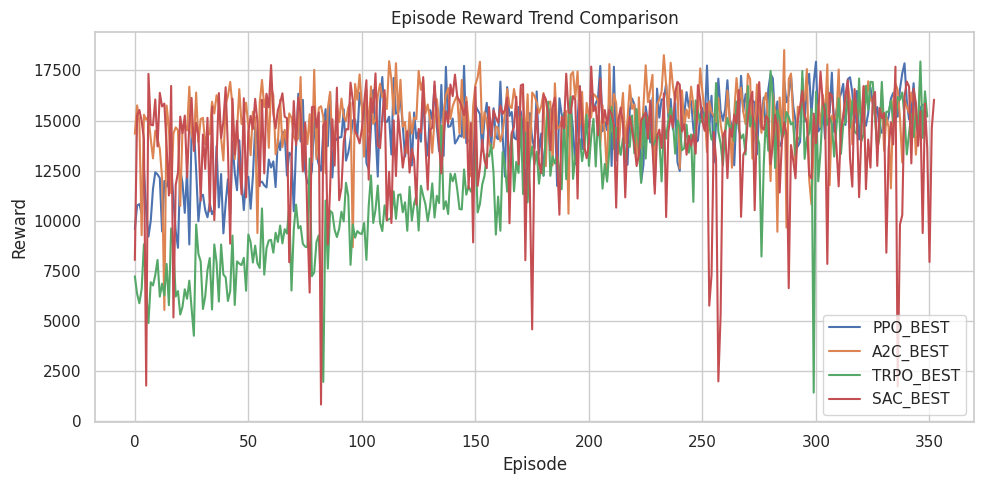

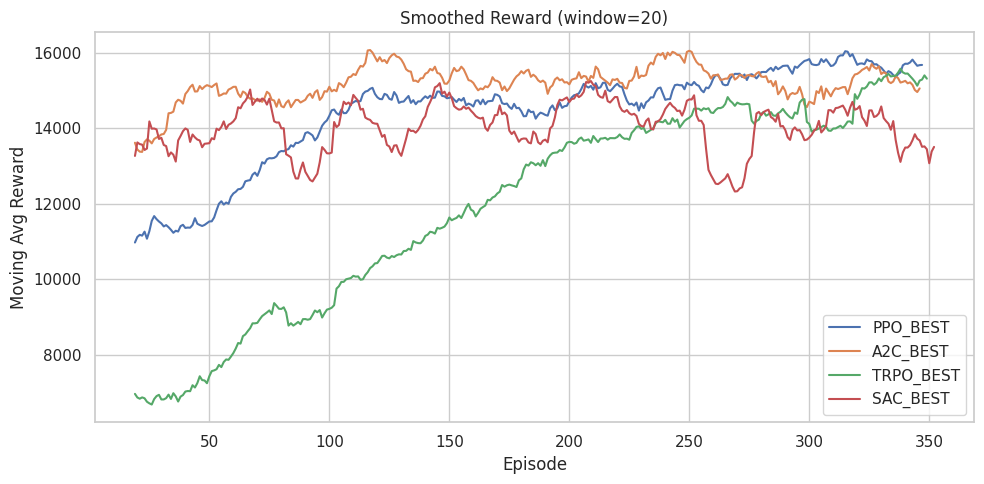

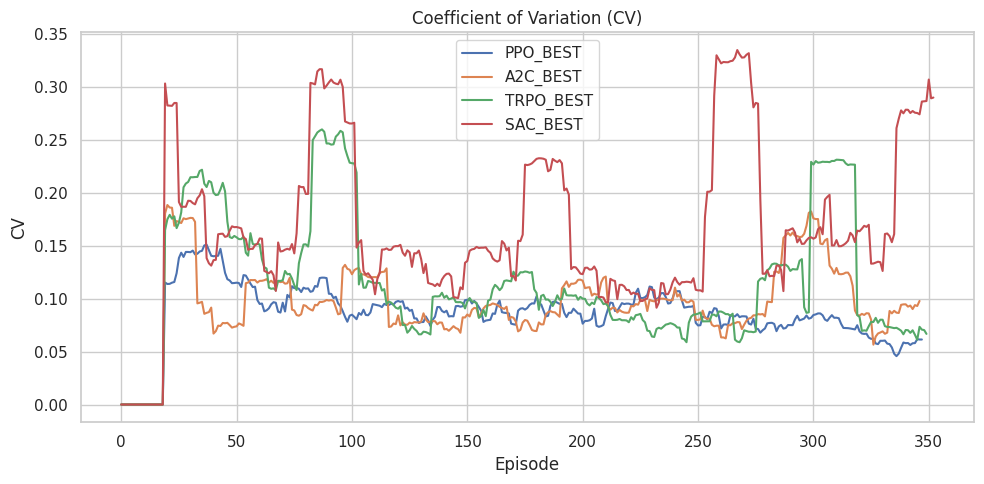

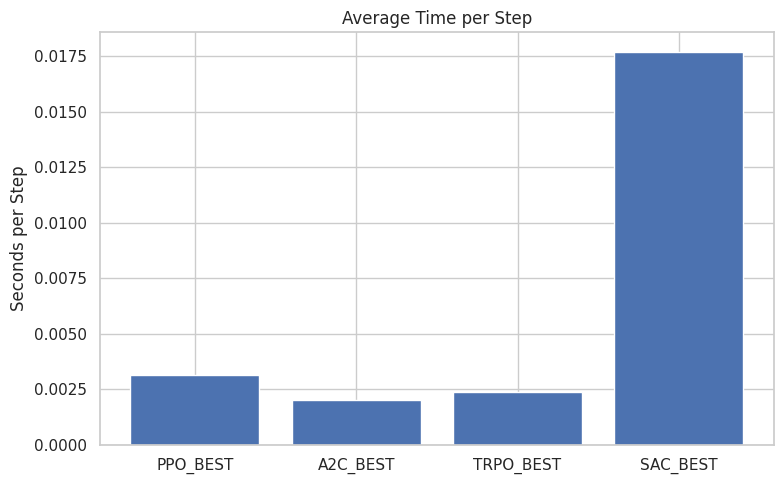

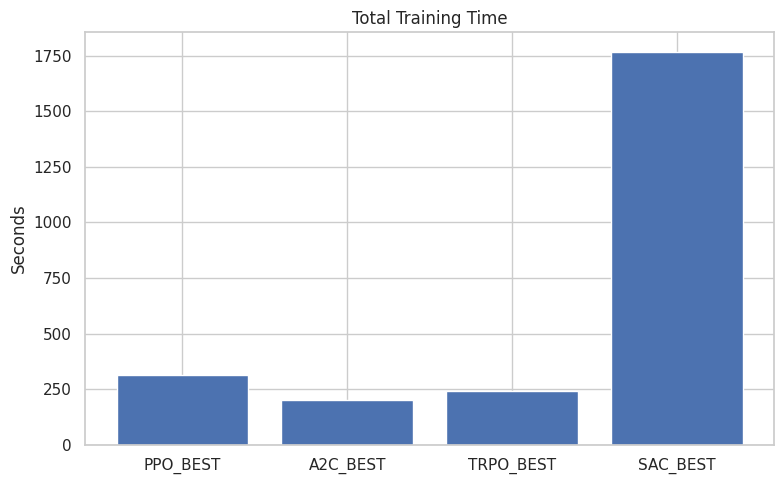

Performance Summary:


,Algorithm,Mean Reward (last 50),Max Reward,Min Reward,Std Reward,Avg Time per Step (s),Total Training Time (s)
0,PPO_BEST,15714.80,17932.92,8649.47,1905.18,0.003132,312.91
1,A2C_BEST,15155.70,18515.00,5550.12,1642.26,0.002011,201.73
2,TRPO_BEST,15170.63,17943.32,1424.52,3165.02,0.002385,239.25
3,SAC_BEST,13916.60,17765.00,830.00,2650.35,0.017691,1767.44



Diagrams are saved at ./figures_comparison_finetuned/ and summary saved as summary_table.csv


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
FIG_DIR = "./figures_comparison_finetuned"
os.makedirs(FIG_DIR, exist_ok=True)

algos = ["ppo_best", "a2c_best", "trpo_best", "sac_best"]

def load_data(algo):
    path = f"./logs/{algo}_logs/monitor.csv"
    df = pd.read_csv(path, skiprows=2, names=["reward", "length", "time"])

    df["episode_time"] = df["time"].diff().fillna(0)
    df["step_time"] = df["episode_time"] / df["length"]
    return df

data = {algo: load_data(algo) for algo in algos}
rewards = {algo: data[algo]["reward"].values for algo in algos}
step_times = {algo: data[algo]["step_time"].values[1:] for algo in algos}
total_times = {algo: data[algo]["time"].iloc[-1] for algo in algos}

def plot_rewards():
    plt.figure(figsize=(10,5))
    for algo in algos:
        plt.plot(rewards[algo], label=algo.upper())
    plt.title("Episode Reward Trend Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/reward_trend.png")
    plt.show()

def plot_smoothed(window=20):
    plt.figure(figsize=(10,5))
    for algo in algos:
        sm = pd.Series(rewards[algo]).rolling(window).mean()
        plt.plot(sm, label=algo.upper())
    plt.title(f"Smoothed Reward (window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Moving Avg Reward")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/reward_smoothed.png")
    plt.show()

def plot_cv(window=20):
    plt.figure(figsize=(10,5))
    for algo in algos:
        series = pd.Series(rewards[algo])
        means = series.rolling(window).mean()
        stds  = series.rolling(window).std()
        cv = (stds / means).fillna(0)
        plt.plot(cv, label=algo.upper())
    plt.title("Coefficient of Variation (CV)")
    plt.xlabel("Episode")
    plt.ylabel("CV")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/reward_cv.png")
    plt.show()

def plot_avg_step_time():
    plt.figure(figsize=(8,5))
    avg_times = [np.mean(step_times[algo]) for algo in algos]
    plt.bar([a.upper() for a in algos], avg_times)
    plt.title("Average Time per Step")
    plt.ylabel("Seconds per Step")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/avg_step_time.png")
    plt.show()

def plot_total_training_time():
    plt.figure(figsize=(8,5))
    total_time_values = [total_times[algo] for algo in algos]
    plt.bar([a.upper() for a in algos], total_time_values)
    plt.title("Total Training Time")
    plt.ylabel("Seconds")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/total_training_time.png")
    plt.show()

plot_rewards()
plot_smoothed(window=20)
plot_cv(window=20)
plot_avg_step_time()
plot_total_training_time()

summary = []
for algo in algos:
    r = rewards[algo]
    t = step_times[algo]
    summary.append({
        "Algorithm": algo.upper(),
        "Mean Reward (last 50)": np.round(r[-50:].mean(),2) if len(r)>=50 else np.nan,
        "Max Reward": np.round(r.max(),2),
        "Min Reward": np.round(r.min(),2),
        "Std Reward": np.round(r.std(),2),
        "Avg Time per Step (s)": np.round(np.mean(t), 6),
        "Total Training Time (s)": np.round(total_times[algo], 2)
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv(f"{FIG_DIR}/summary_table.csv", index=False)

print("Performance Summary:")
display(summary_df)
print(f"\nDiagrams are saved at {FIG_DIR}/ and summary saved as summary_table.csv")
